In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

dirs = ['../DataGeneration/Python', './net/']
for d in dirs:
    if d not in sys.path:
        sys.path.append(d)

import Sample
import Dataloader

from Transformer import Transformer

In [2]:
## Boilerplate setup code

TRAIN_DATASET_PATH = '../Dataset/CC10k.npy'
VAL_DATASET_PATH = '../Dataset/CCVal300.npy'
N_WORKERS = 0

# From data
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
BATCH_SIZE = 1

# Load some of our data
data_train = Dataloader.formattedLoader(d_output, TRAIN_DATASET_PATH) # Get input data formatted for network
data_val = Dataloader.formattedLoader(d_output, VAL_DATASET_PATH) # Get input data formatted for network

dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

In [51]:
def load_model(model_path):
    state_dict = torch.load(model_path)
    optimizePrime = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
    optimizePrime.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(optimizePrime.parameters(), lr=LR)
    return optimizePrime


def show_samples(model):
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

    dl = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

    for x, y in dl:
        break

    for i, ax in enumerate(axs.flat):
        X = model(x.float())[i]
        X = X.detach().numpy()
        ax.plot(range(len(y[i])), y[i])
        
        ax.plot(range(len(X)), X)
        ax.legend(["Target", "Prediction"])
        ax.set_title(f"Plot {i+1}")
        
    plt.tight_layout()
    plt.show()

In [4]:
def fit(model, optimizer, loss_function, EPOCHS, model_save_path, perturb=False, noise_scale=.1):
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_loss_best = np.inf 


    for epoch in range(EPOCHS):
        with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{EPOCHS}]") as pbar:
            
            # Training phase
            model.train()
            running_loss = 0

            for i, (x, y) in enumerate(dataloader_train):
                
                if perturb:
                    # Add random noise to the input tensor
                    noise_tensor = torch.randn_like(x) * noise_scale  # 0.1 is the noise scale
                    perturbed_input = x + noise_tensor                

                # Forward pass
                optimizer.zero_grad()
                x = x.float()
                yhat = model(x)
                loss = loss_function(y.float(), yhat)

                # Back pass
                loss.backward()
                optimizer.step()

                running_loss+= loss.item()
                pbar.set_postfix({'total loss': running_loss})
                pbar.update(x.shape[0])

            performance = running_loss / len(dataloader_train.dataset)
            epoch_train_loss.append(performance)
            print(f"Epoch {epoch} train_loss: {performance}")

            # Validation phase
            model.eval()
            running_loss = 0

            with torch.no_grad():
                for i, (x, y) in enumerate(dataloader_val):
                    
                    # Forward pass
                    x = x.float()
                    yhat = model(x)
                    loss = loss_function(y.float(), yhat)
                    running_loss+= loss.item()

                # Loss per sample
                performance = running_loss / len(dataloader_val.dataset)
                epoch_val_loss.append(performance)
                print(f"Epoch {epoch} val_loss: {performance}")

        if epoch_val_loss[-1] < epoch_loss_best:
            epoch_loss_best = performance
            torch.save(model.state_dict(), model_save_path)
    return epoch_train_loss, epoch_val_loss    


# Model 5 (Variance Enforcement)

In [15]:
## Model 4 Architecture ##

d_input = 5 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10


# Model hyperparameters
BATCH_SIZE = 4
D_MODEL = 32
q = 6 
v = 6
h = 6
Ne = 8
Nd = 8
DROPOUT = 0.5


model5 = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT, noise_scale=0.15) 
model5.init_weights()
model_save_path = f'Checkpoints/model5_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'


dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

varMSE = nn.MSELoss()
mse = nn.MSELoss()

#### Custom Loss Function ####
def var_loss(outputs, targets): 
    return varMSE(torch.var(outputs, dim=0), torch.var(targets, dim=0))

def criterion(outputs, targets):
    return var_loss(outputs, targets) + mse(outputs, targets)

def show_samples(model):
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

    dl = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

    for x, y in dl:
        break

    for i, ax in enumerate(axs.flat):
        X = model(x.float())[i]
        X = X.detach().numpy()
        ax.plot(range(len(y[i])), y[i])
        ax.plot(range(len(X)), X)
        ax.legend(["Target", "Prediction"])
        ax.set_title(f"Plot {i+1}")
    plt.tight_layout()
    plt.show()



In [16]:
def show_samples(model):
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

    dl = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

    for x, y in dl:
        break

    for i, ax in enumerate(axs.flat):
        X = model(x.float())[i]
        X = X.detach().numpy()
        ax.plot(range(len(y[i])), y[i])
        ax.plot(range(len(X)), X)
        ax.legend(["Target", "Prediction"])
        ax.set_title(f"Plot {i+1}")
    plt.tight_layout()
    plt.show()

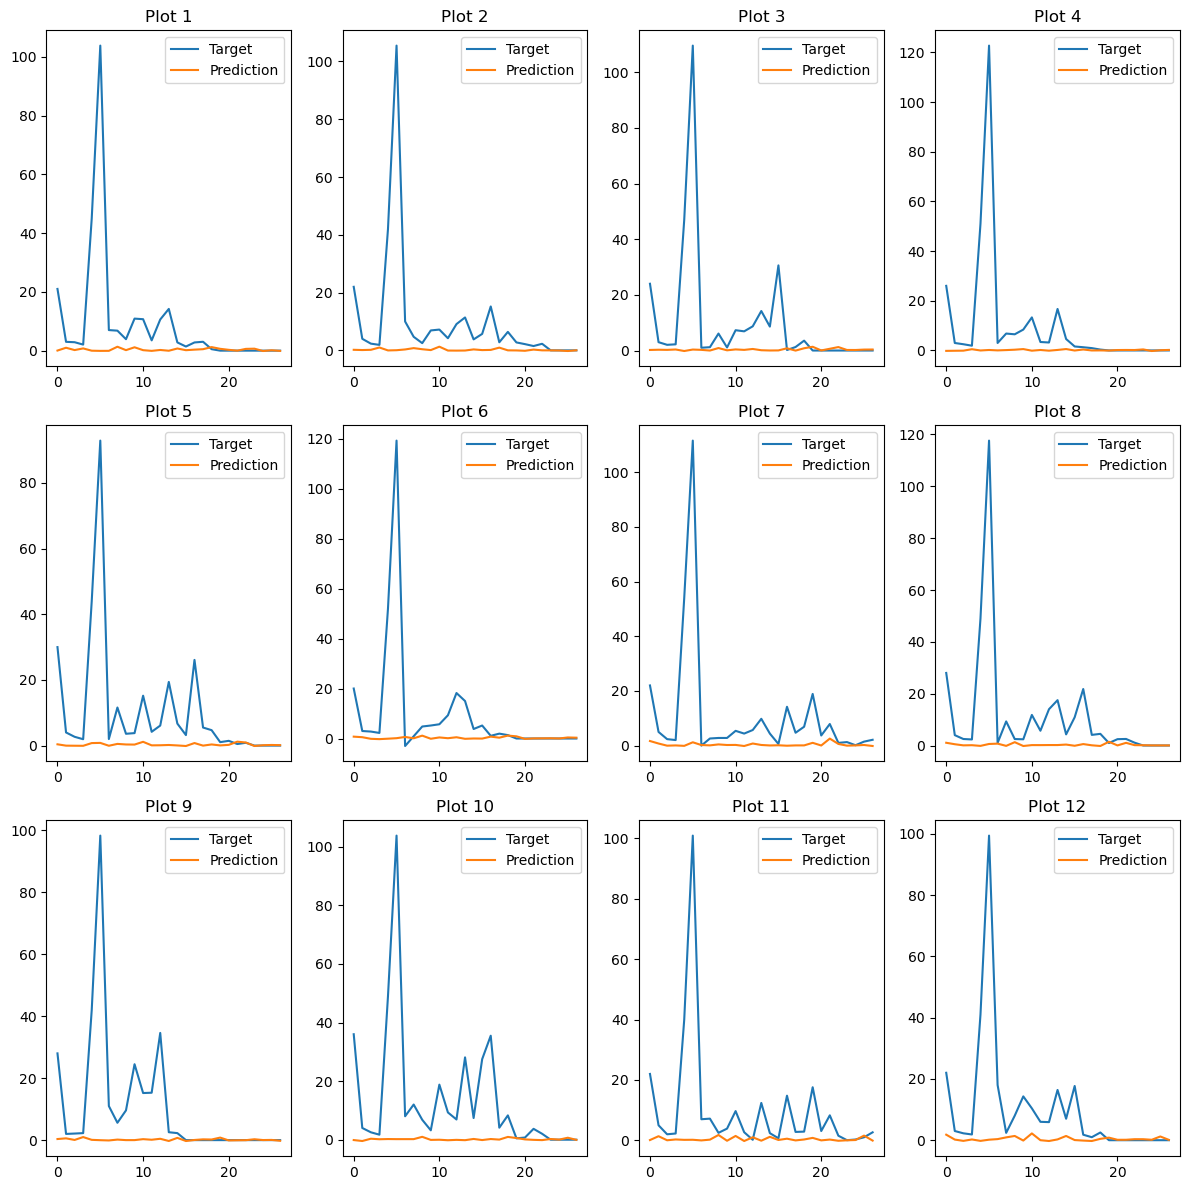

In [17]:
show_samples(model5)


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:58<00:00, 85.20it/s, total loss=6.39e+5]

Epoch 0 train_loss: 63.866206002998354


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:59<00:00, 83.75it/s, total loss=6.39e+5]

Epoch 0 val_loss: 13.931871293385823


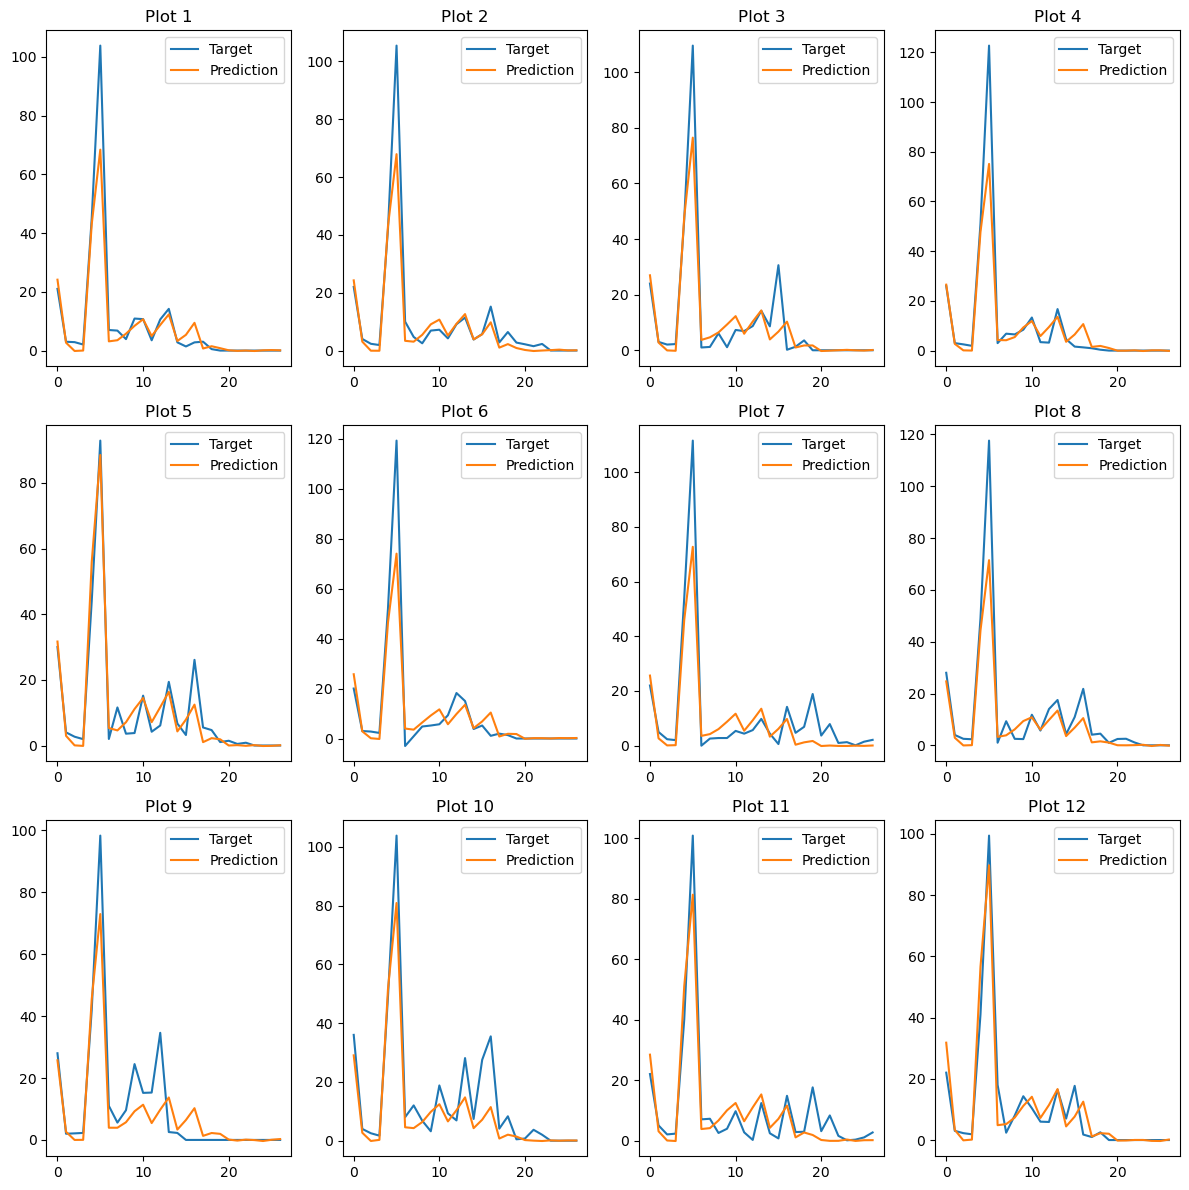

[Epoch   1/2]: 100%|█████████▉| 9996/10000 [01:58<00:00, 85.87it/s, total loss=6.52e+6]

Epoch 0 train_loss: 652.1211581680298


[Epoch   1/2]: 100%|██████████| 10000/10000 [01:59<00:00, 83.78it/s, total loss=6.52e+6]


Epoch 0 val_loss: 575.8267205810547


[Epoch   2/2]: 100%|██████████| 10000/10000 [01:58<00:00, 85.56it/s, total loss=4.98e+6]

Epoch 1 train_loss: 498.040680682373


[Epoch   2/2]: 100%|██████████| 10000/10000 [02:00<00:00, 83.27it/s, total loss=4.98e+6]

Epoch 1 val_loss: 584.0815804036458


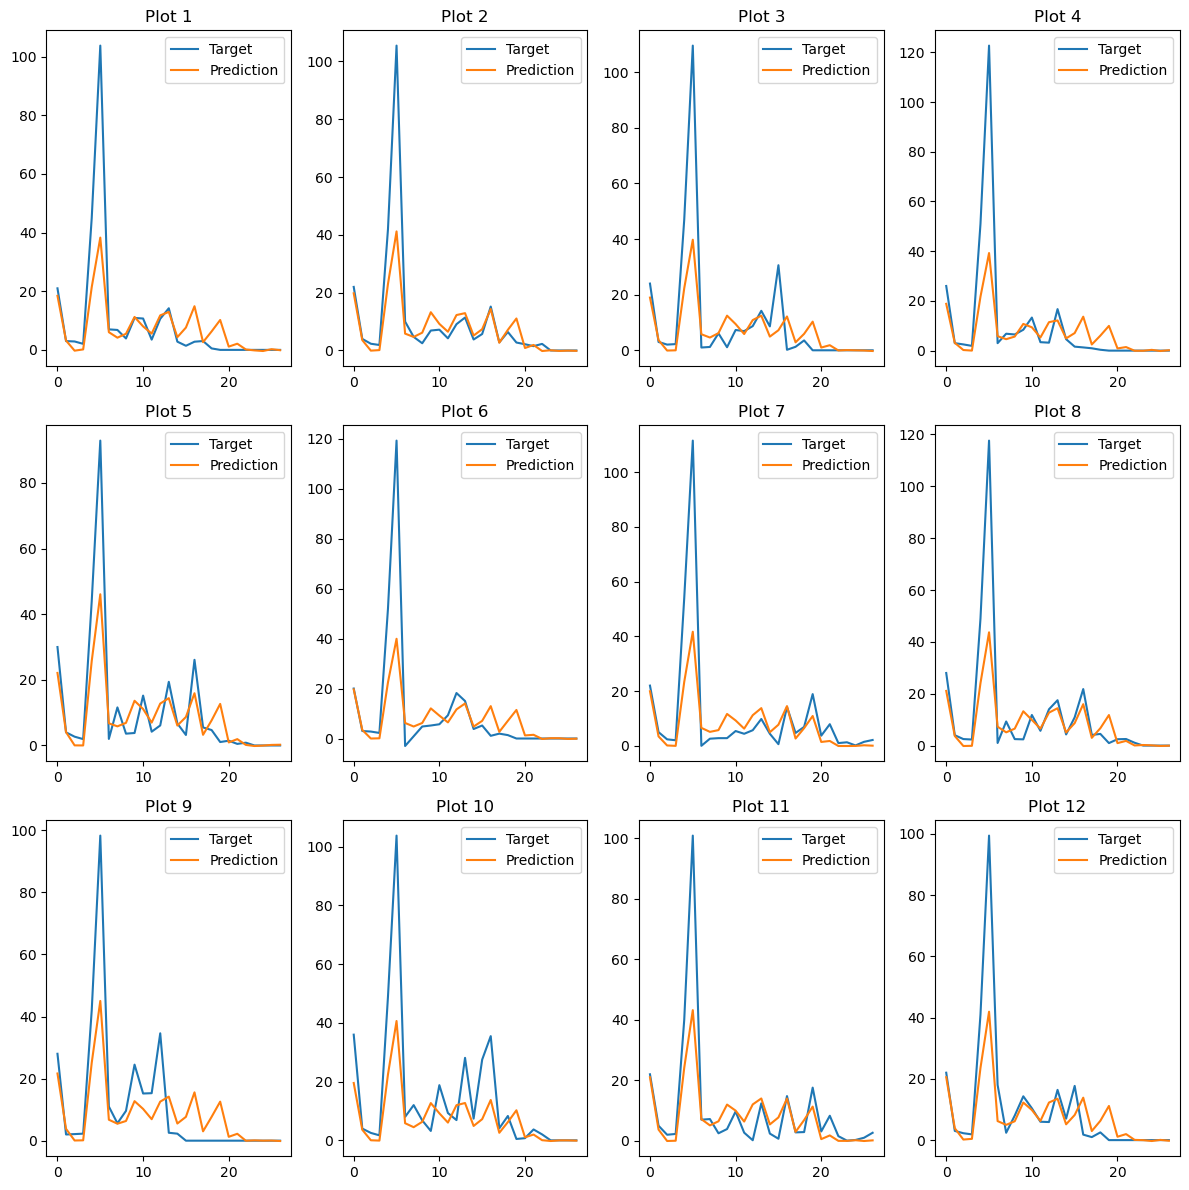

[Epoch   1/1]: 100%|██████████| 10000/10000 [01:56<00:00, 85.82it/s, total loss=3.58e+5]

Epoch 0 train_loss: 35.76982027816773


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:58<00:00, 84.68it/s, total loss=3.58e+5]

Epoch 0 val_loss: 15.752993405659993


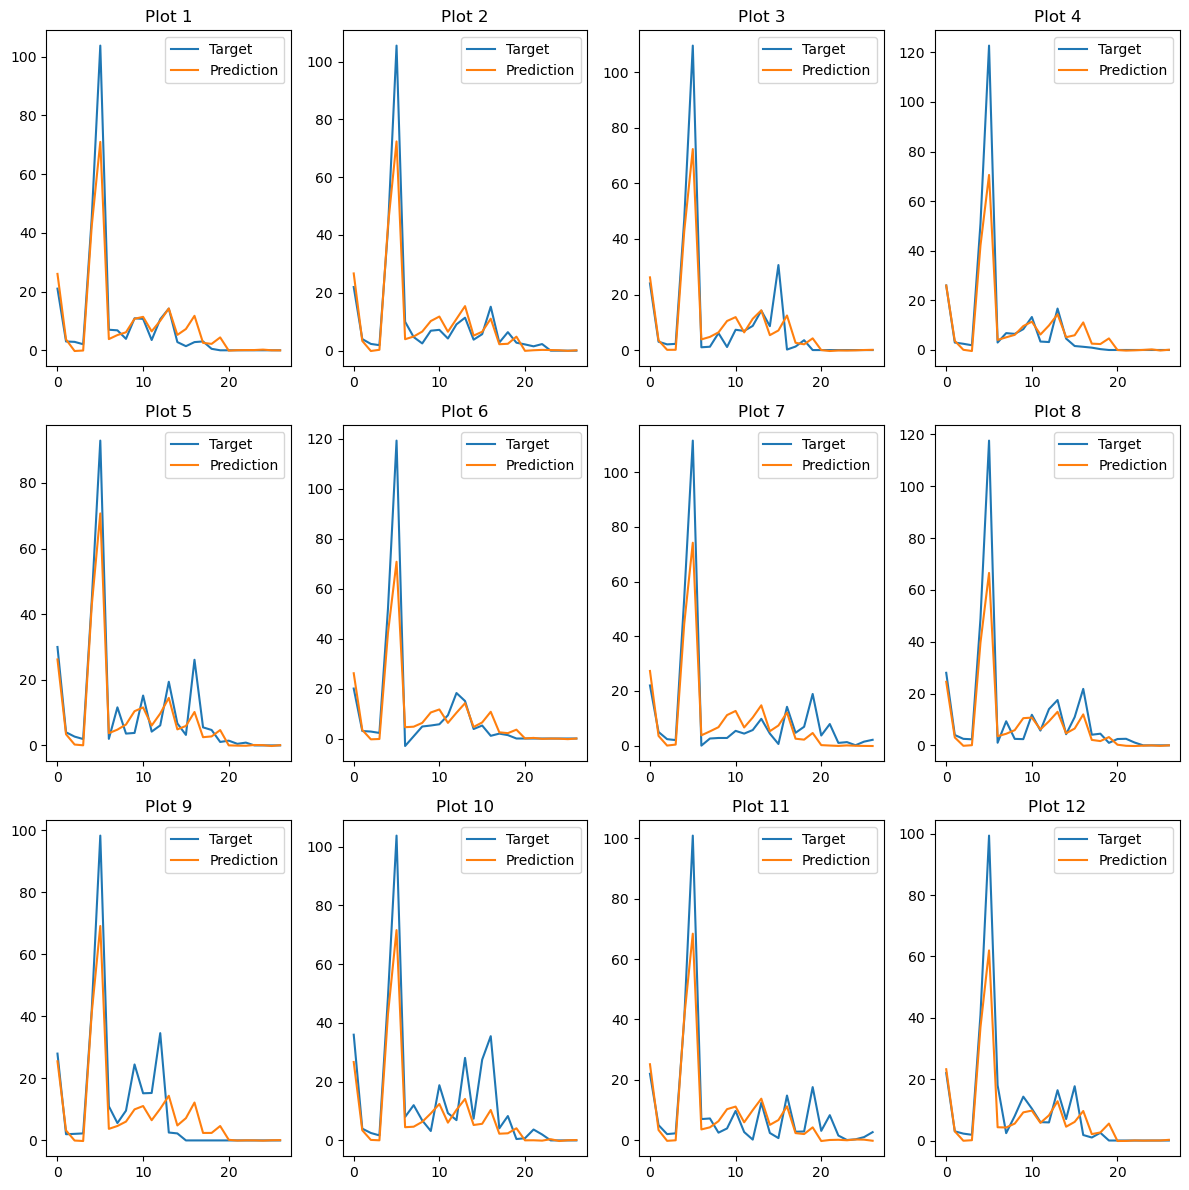

[Epoch   1/2]: 100%|█████████▉| 9996/10000 [01:56<00:00, 88.10it/s, total loss=5.35e+6]

Epoch 0 train_loss: 534.7965358886719


[Epoch   1/2]: 100%|██████████| 10000/10000 [01:57<00:00, 84.84it/s, total loss=5.35e+6]


Epoch 0 val_loss: 578.1246419270833


[Epoch   2/2]: 100%|█████████▉| 9996/10000 [01:56<00:00, 87.37it/s, total loss=4.88e+6]

Epoch 1 train_loss: 488.0479742202759


[Epoch   2/2]: 100%|██████████| 10000/10000 [01:57<00:00, 85.22it/s, total loss=4.88e+6]

Epoch 1 val_loss: 581.1187980143229


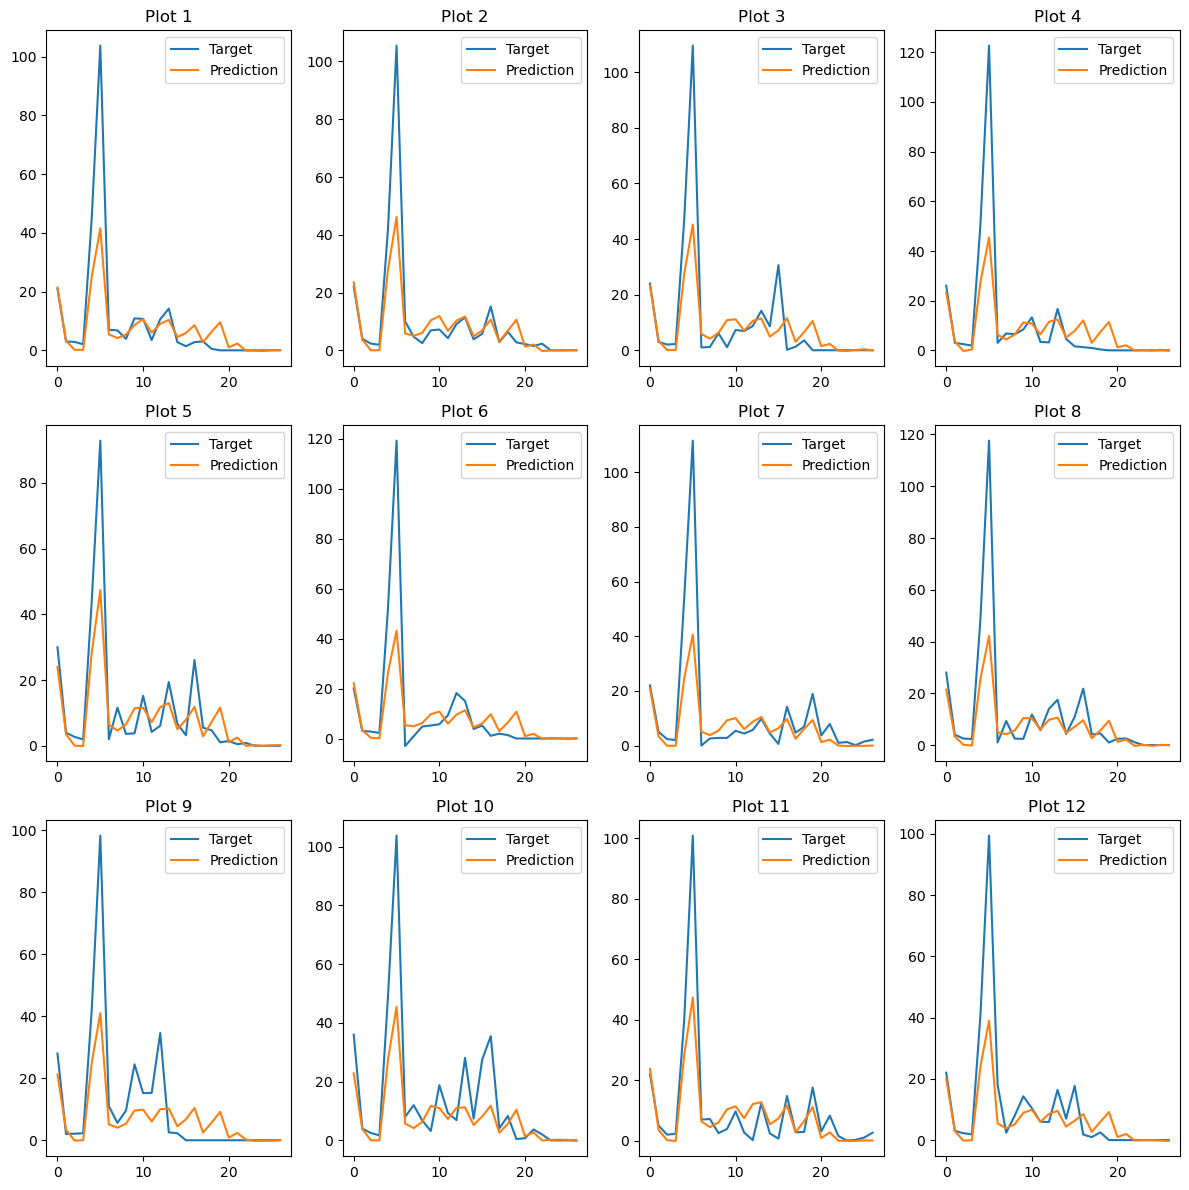

[Epoch   1/1]: 100%|█████████▉| 9996/10000 [01:55<00:00, 87.96it/s, total loss=3.17e+5]

Epoch 0 train_loss: 31.703055814361573


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:56<00:00, 85.89it/s, total loss=3.17e+5]

Epoch 0 val_loss: 13.956910343170167


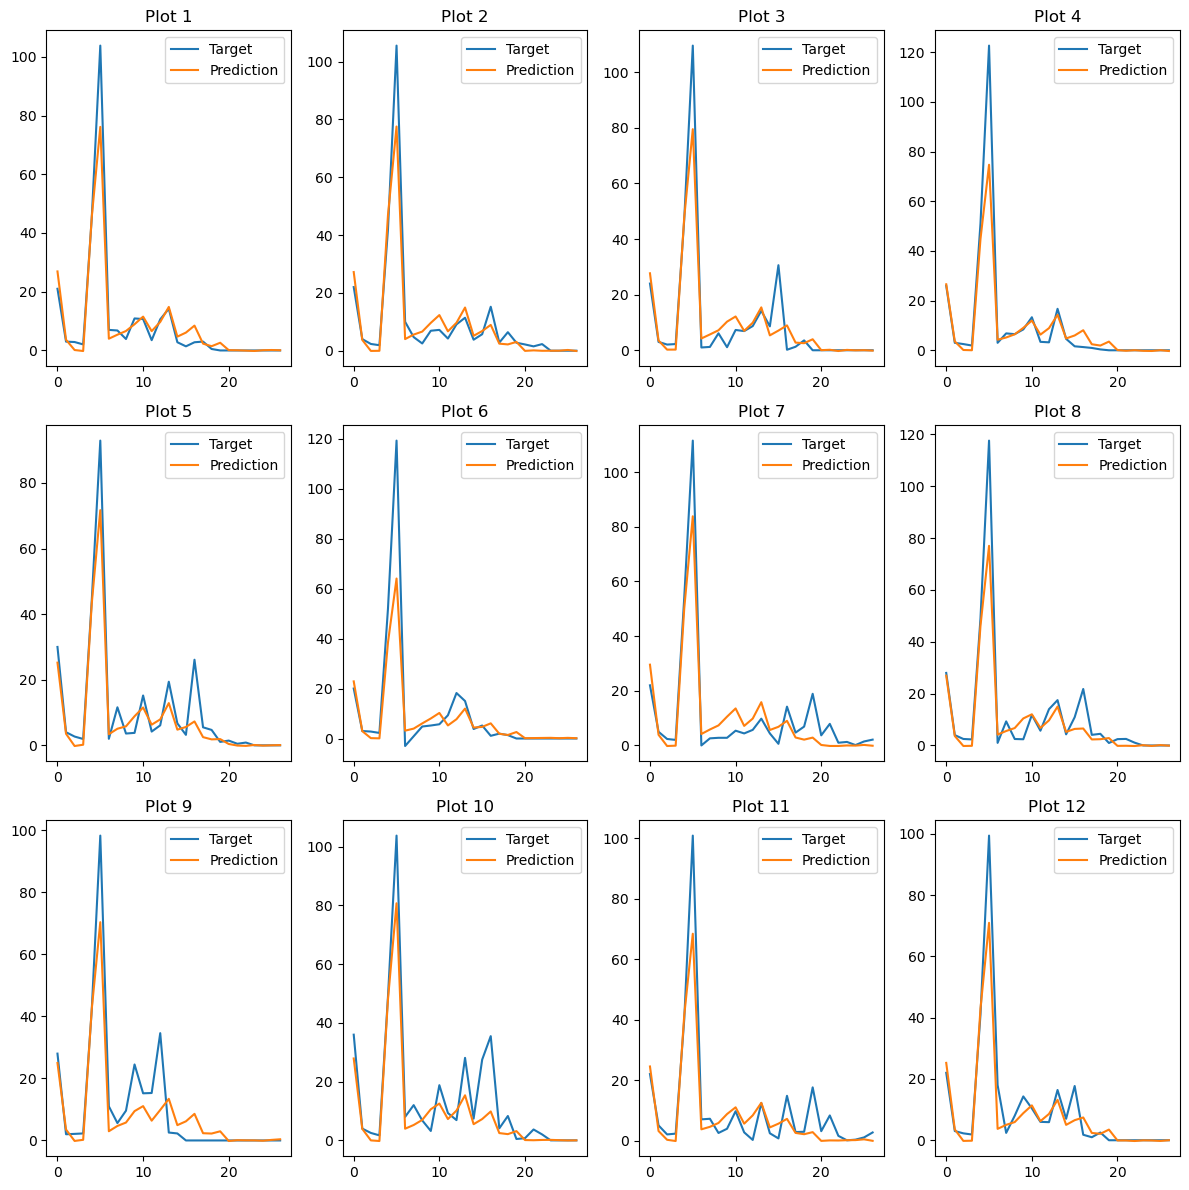

[Epoch   1/2]: 100%|██████████| 10000/10000 [01:54<00:00, 87.63it/s, total loss=5.1e+6]

Epoch 0 train_loss: 510.2438216506958


[Epoch   1/2]: 100%|██████████| 10000/10000 [01:55<00:00, 86.33it/s, total loss=5.1e+6]


Epoch 0 val_loss: 578.8544441731771


[Epoch   2/2]: 100%|█████████▉| 9996/10000 [01:56<00:00, 90.75it/s, total loss=4.59e+6]

Epoch 1 train_loss: 459.3133521270752


[Epoch   2/2]: 100%|██████████| 10000/10000 [01:57<00:00, 84.85it/s, total loss=4.59e+6]

Epoch 1 val_loss: 582.1611533610026


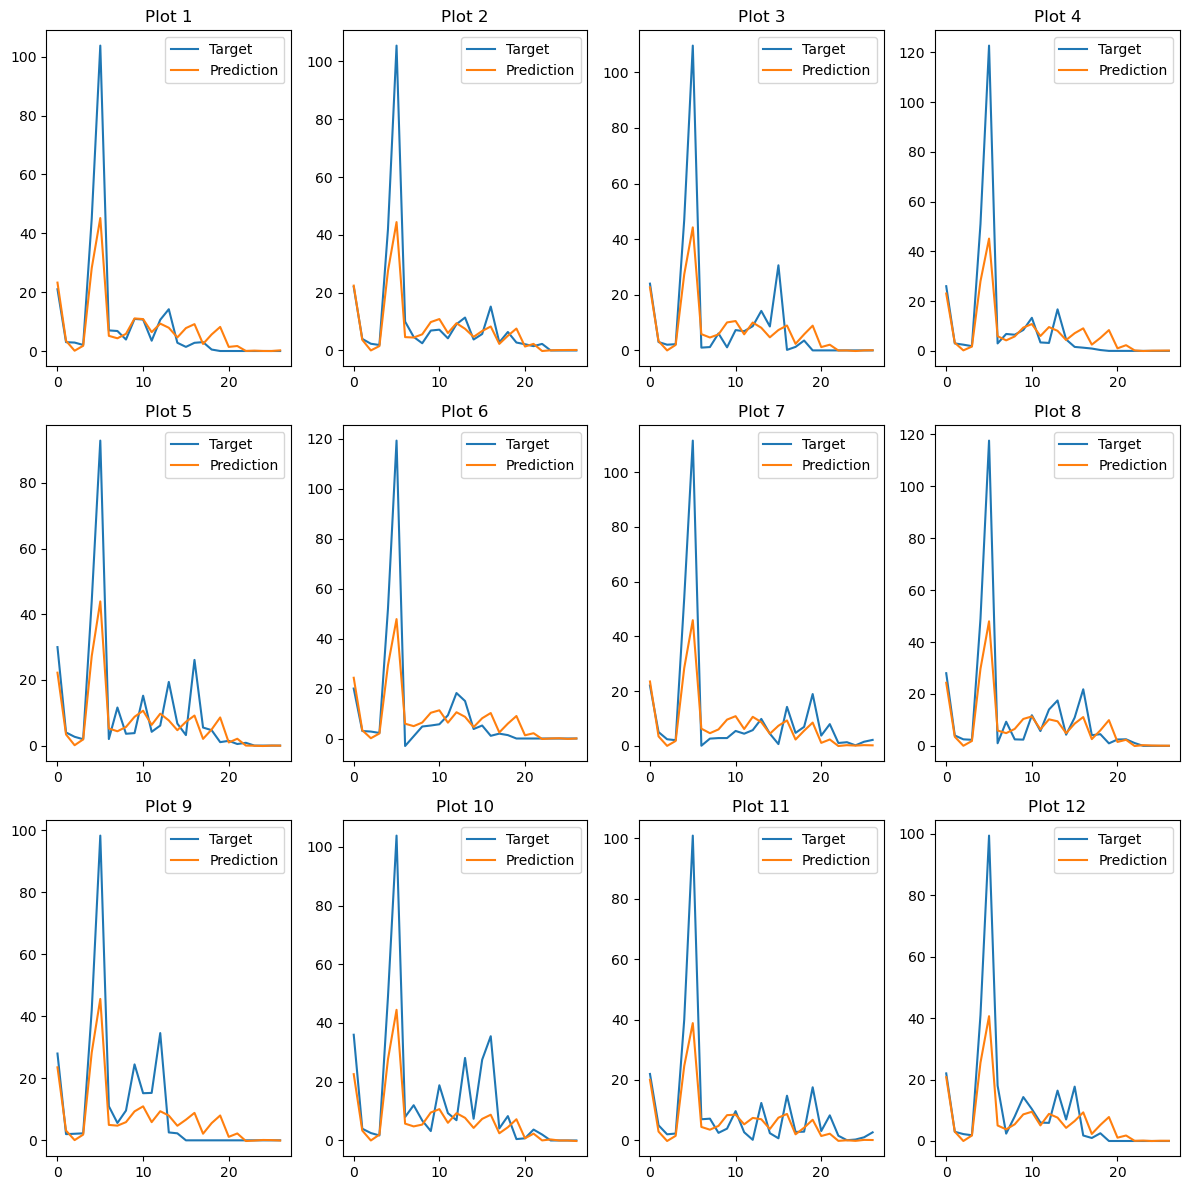

[Epoch   1/1]: 100%|█████████▉| 9996/10000 [01:54<00:00, 88.19it/s, total loss=3e+5]   

Epoch 0 train_loss: 29.952987829208375


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:55<00:00, 86.27it/s, total loss=3e+5]

Epoch 0 val_loss: 13.469255479176839


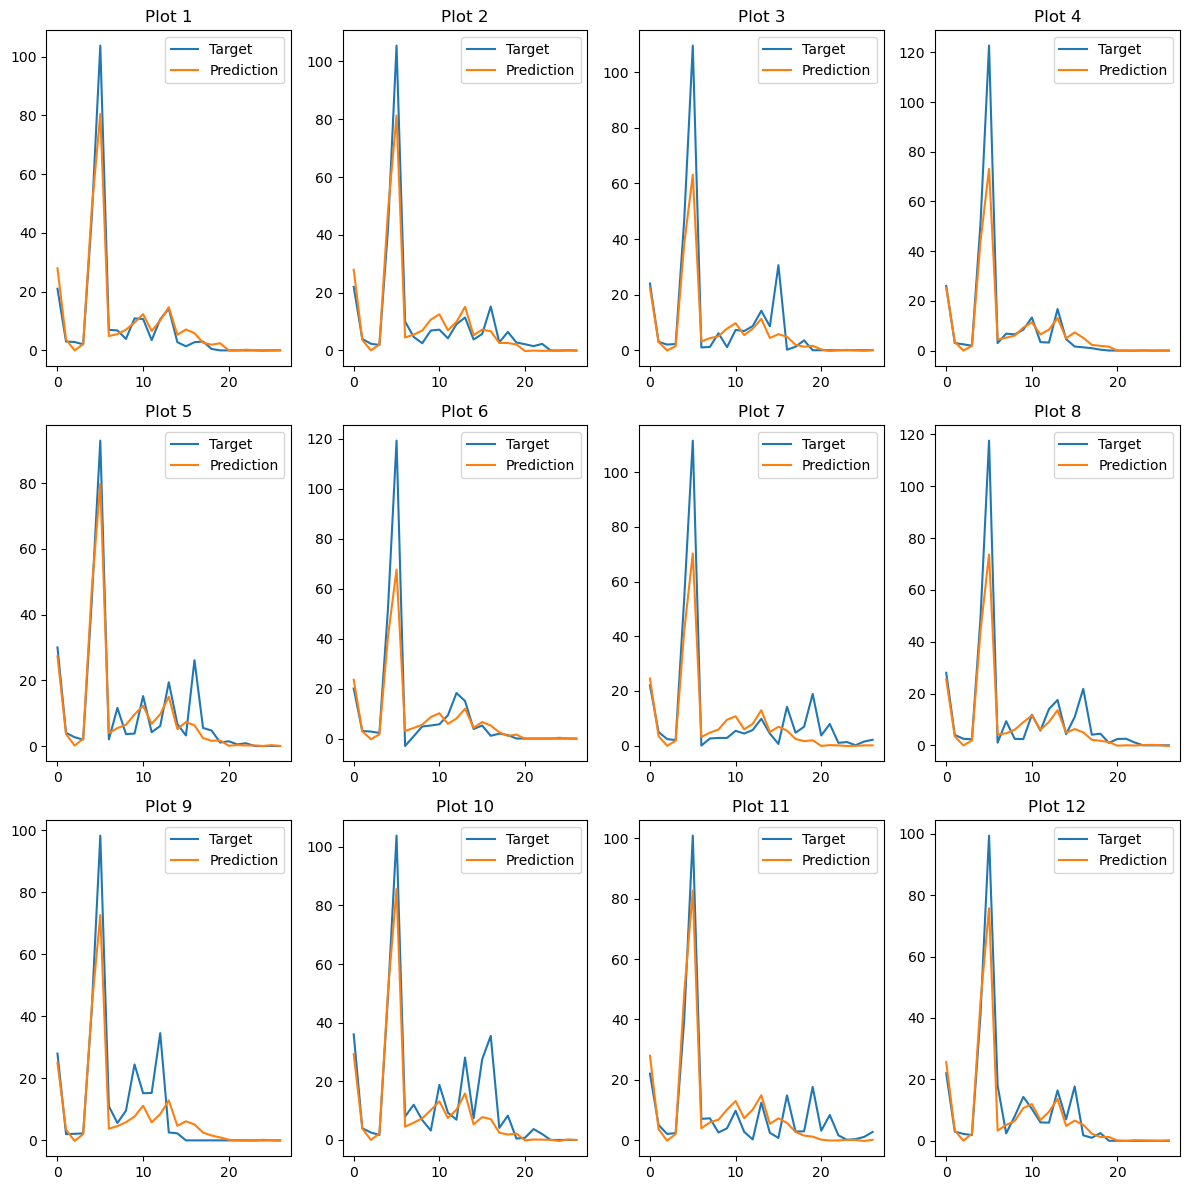

In [19]:

### 0th round: MSELoss, low LR ###
EPOCHS= 1
LR = .00015

base_loss = nn.MSELoss()
v_loss = criterion
optimizer = torch.optim.Adam(model5.parameters(), lr=LR)

train_loss4Fine, val_loss4Fine = fit(model5, optimizer, base_loss, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
show_samples(model5)


for i in range(3):
    ### 1st round: Enforce variance ###
    EPOCHS= 2
    LR = .0005
    optimizer = torch.optim.Adam(model5.parameters(), lr=LR)
    train_loss4Fine, val_loss4Fine = fit(model5, optimizer, v_loss, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
    show_samples(model5)

    ### Second Round: MSELoss ### 
    EPOCHS= 1
    LR = .00005
    optimizer = torch.optim.Adam(model5.parameters(), lr=LR)
    train_loss4Fine, val_loss4Fine = fit(model5, optimizer, base_loss, EPOCHS, model_save_path, perturb=True, noise_scale=0.15)
    show_samples(model5)


[Epoch   1/3]: 100%|██████████| 10000/10000 [01:09<00:00, 147.14it/s, total loss=2.6e+6]

Epoch 0 train_loss: 260.38633563842774


[Epoch   1/3]: 100%|██████████| 10000/10000 [01:10<00:00, 142.14it/s, total loss=2.6e+6]


Epoch 0 val_loss: 156.18246765136718


[Epoch   2/3]: 100%|██████████| 10000/10000 [01:08<00:00, 146.75it/s, total loss=1.46e+6]

Epoch 1 train_loss: 145.72550244445802


[Epoch   2/3]: 100%|██████████| 10000/10000 [01:09<00:00, 143.76it/s, total loss=1.46e+6]


Epoch 1 val_loss: 113.55621907552083


[Epoch   3/3]: 100%|██████████| 10000/10000 [01:09<00:00, 147.44it/s, total loss=1.3e+6]

Epoch 2 train_loss: 130.42229940185547


[Epoch   3/3]: 100%|██████████| 10000/10000 [01:10<00:00, 142.18it/s, total loss=1.3e+6]

Epoch 2 val_loss: 105.39351928710937


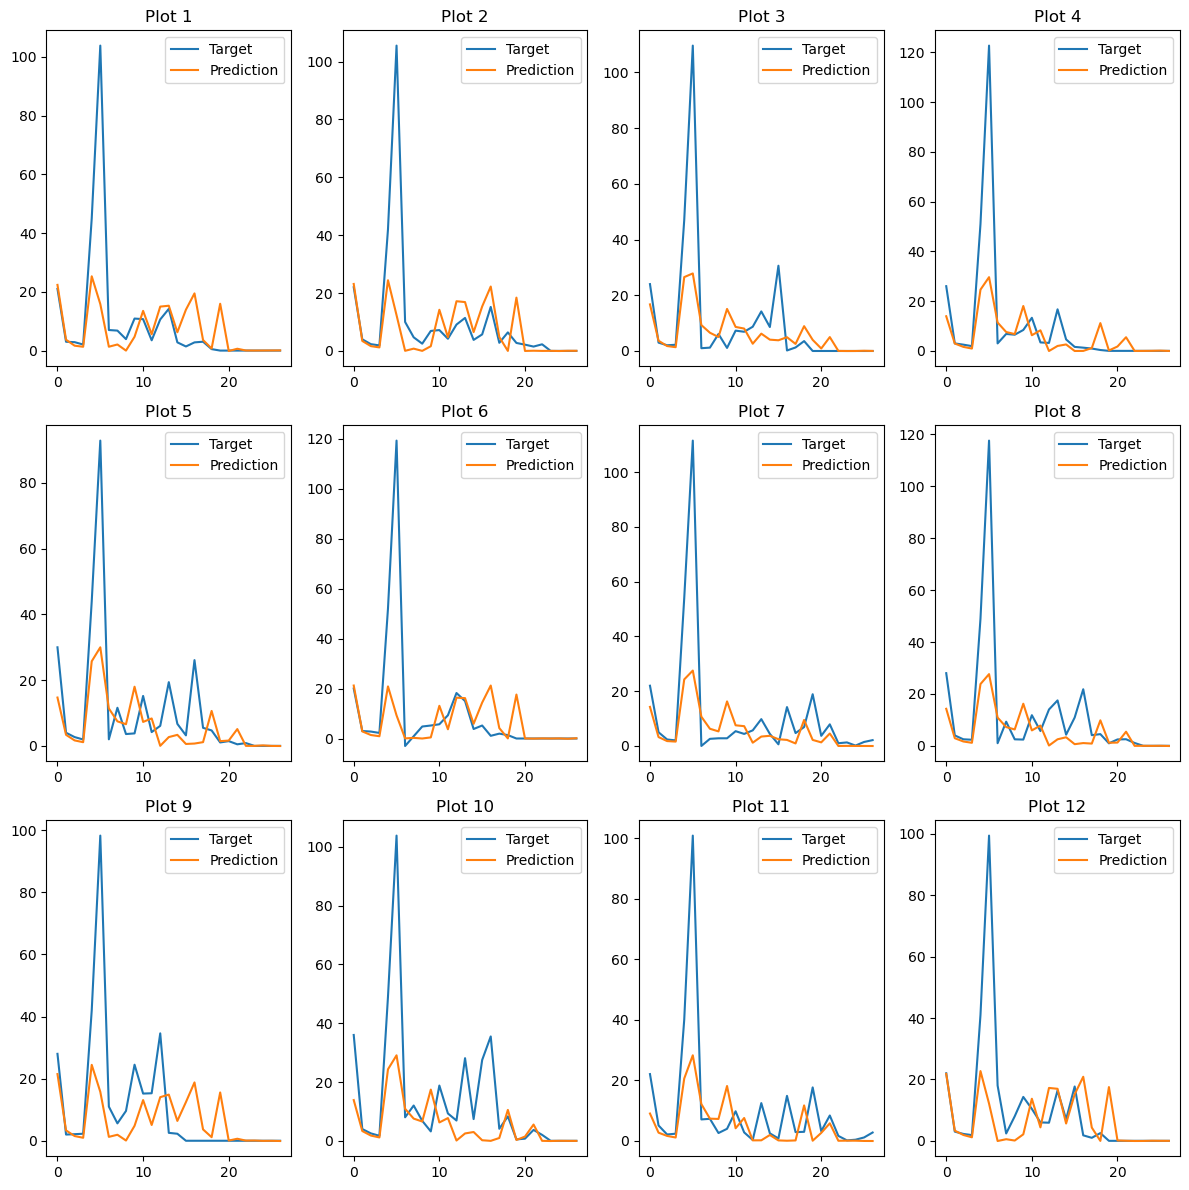

[Epoch   1/1]: 100%|██████████| 10000/10000 [01:07<00:00, 148.97it/s, total loss=3.18e+5]

Epoch 0 train_loss: 31.791889749145508


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:08<00:00, 146.37it/s, total loss=3.18e+5]

Epoch 0 val_loss: 23.804347178141278


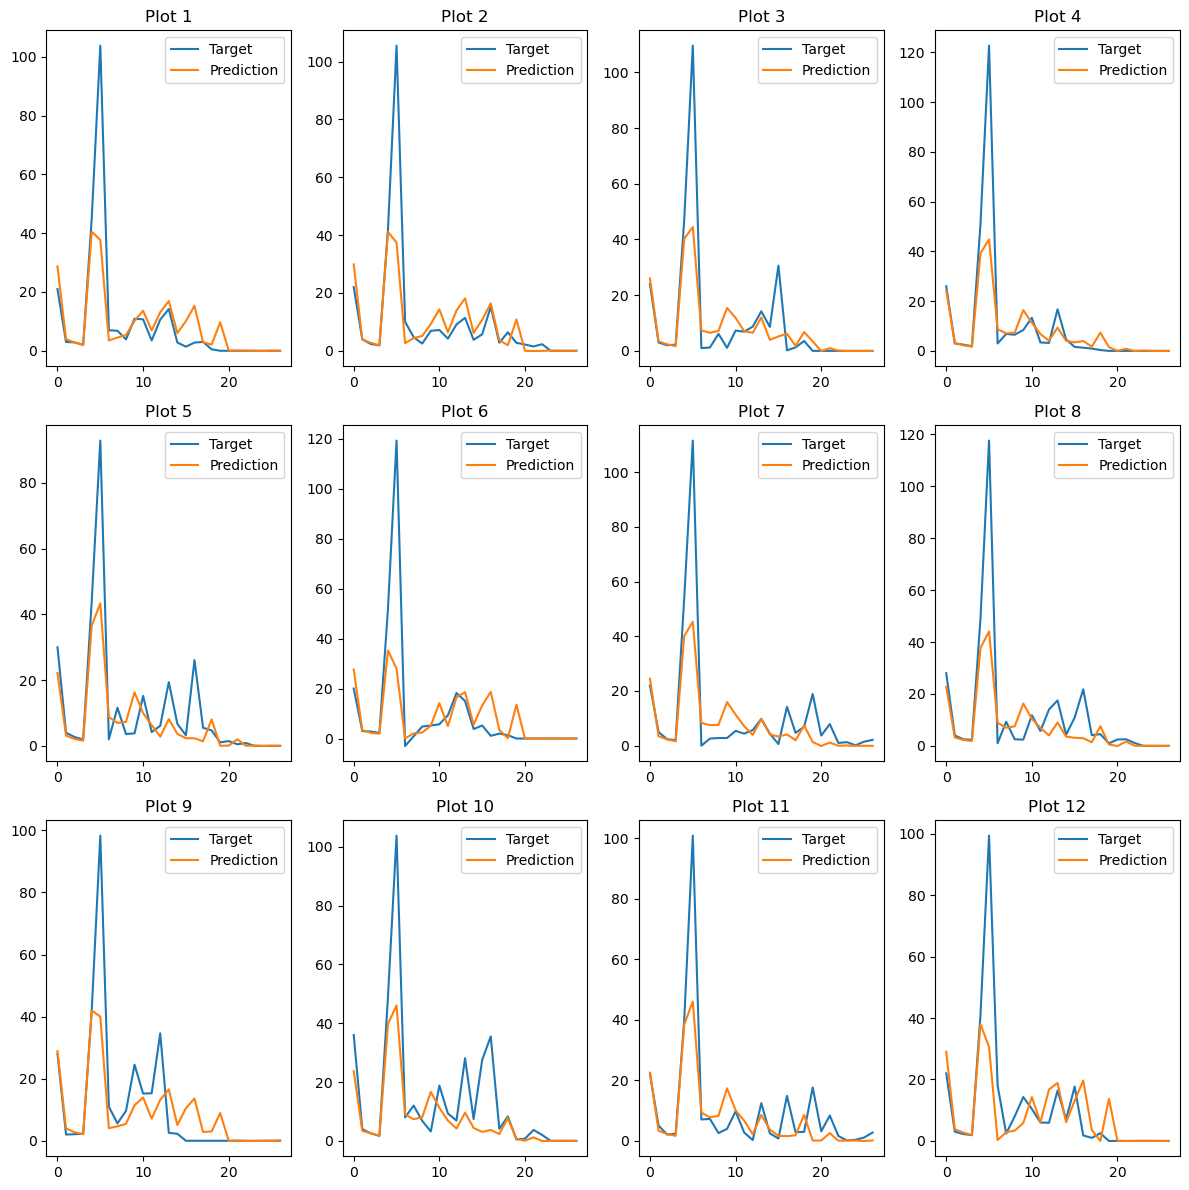

[Epoch   1/3]: 100%|██████████| 10000/10000 [01:07<00:00, 146.98it/s, total loss=1.25e+6]

Epoch 0 train_loss: 124.9772471282959


[Epoch   1/3]: 100%|██████████| 10000/10000 [01:08<00:00, 146.11it/s, total loss=1.25e+6]


Epoch 0 val_loss: 98.10467244466146


[Epoch   2/3]: 100%|██████████| 10000/10000 [01:08<00:00, 145.85it/s, total loss=1.18e+6]

Epoch 1 train_loss: 118.09705604248047


[Epoch   2/3]: 100%|██████████| 10000/10000 [01:09<00:00, 144.08it/s, total loss=1.18e+6]


Epoch 1 val_loss: 93.4146528116862


[Epoch   3/3]: 100%|██████████| 10000/10000 [01:08<00:00, 150.61it/s, total loss=1.16e+6]

Epoch 2 train_loss: 116.35107192230224


[Epoch   3/3]: 100%|██████████| 10000/10000 [01:09<00:00, 143.79it/s, total loss=1.16e+6]

Epoch 2 val_loss: 95.86889282226562


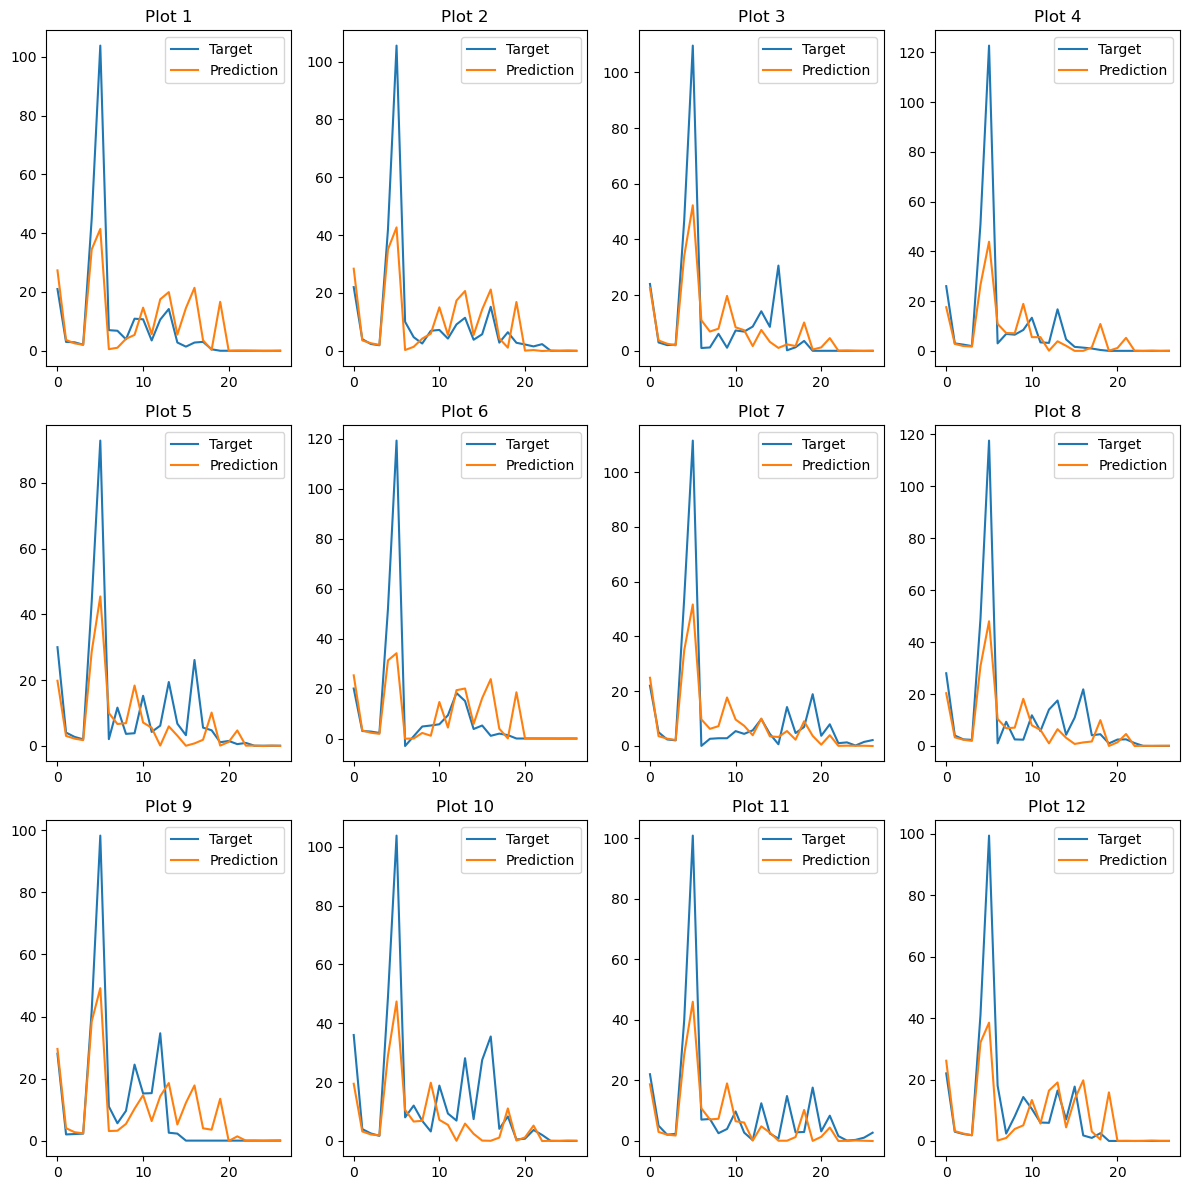

[Epoch   1/1]: 100%|██████████| 10000/10000 [01:07<00:00, 150.16it/s, total loss=1.6e+5]

Epoch 0 train_loss: 15.999574694061279


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:08<00:00, 146.34it/s, total loss=1.6e+5]

Epoch 0 val_loss: 9.816683184305827


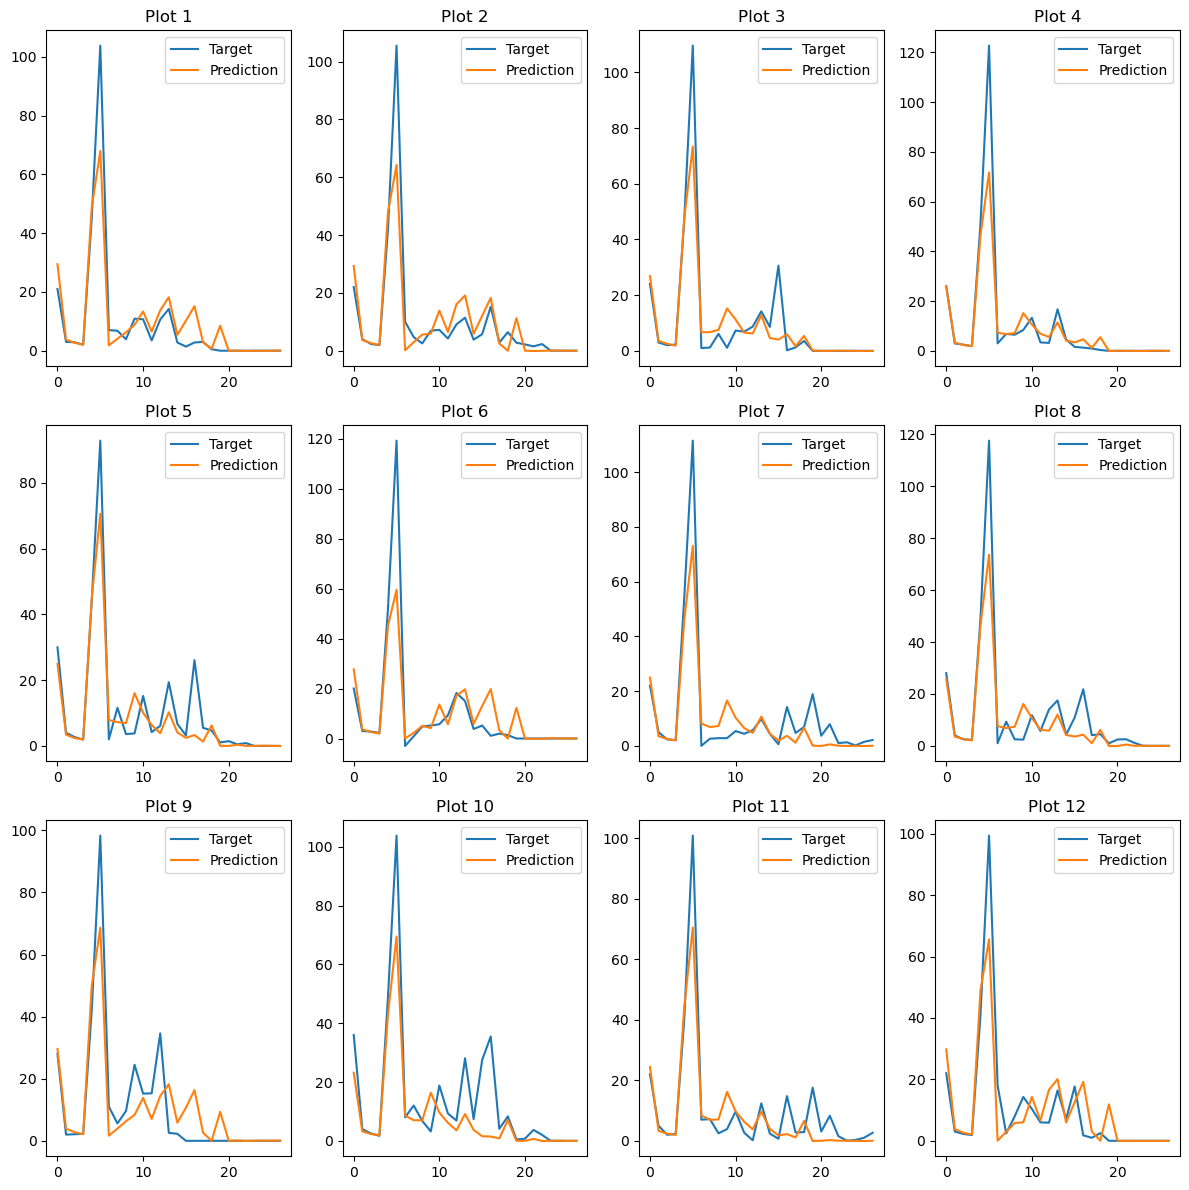

[Epoch   1/3]: 100%|██████████| 10000/10000 [01:09<00:00, 147.90it/s, total loss=1.16e+6]

Epoch 0 train_loss: 116.24335701599121


[Epoch   1/3]: 100%|██████████| 10000/10000 [01:10<00:00, 142.55it/s, total loss=1.16e+6]


Epoch 0 val_loss: 91.1316047668457


[Epoch   2/3]: 100%|██████████| 10000/10000 [01:08<00:00, 148.98it/s, total loss=1.11e+6]

Epoch 1 train_loss: 111.49285827178954


[Epoch   2/3]: 100%|██████████| 10000/10000 [01:09<00:00, 144.44it/s, total loss=1.11e+6]


Epoch 1 val_loss: 96.3089877319336


[Epoch   3/3]: 100%|██████████| 10000/10000 [01:07<00:00, 150.61it/s, total loss=1.09e+6]

Epoch 2 train_loss: 108.56627552185059


[Epoch   3/3]: 100%|██████████| 10000/10000 [01:07<00:00, 147.44it/s, total loss=1.09e+6]

Epoch 2 val_loss: 93.22631871541341


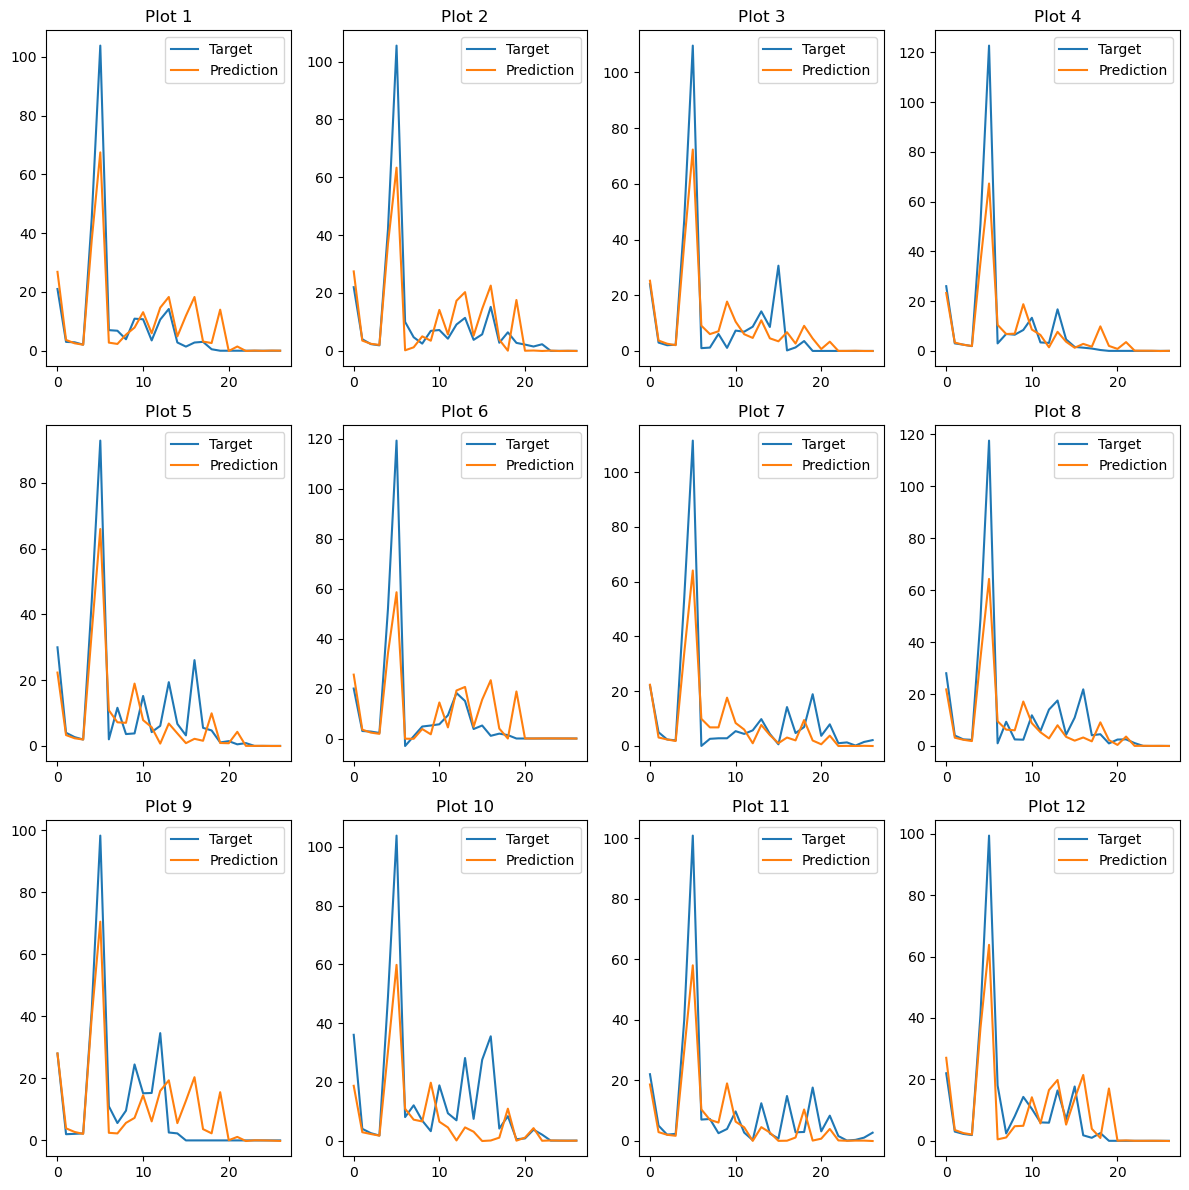

[Epoch   1/1]: 100%|██████████| 10000/10000 [01:06<00:00, 152.09it/s, total loss=8.83e+4]

Epoch 0 train_loss: 8.83431642780304


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:06<00:00, 149.38it/s, total loss=8.83e+4]

Epoch 0 val_loss: 4.831161594390869


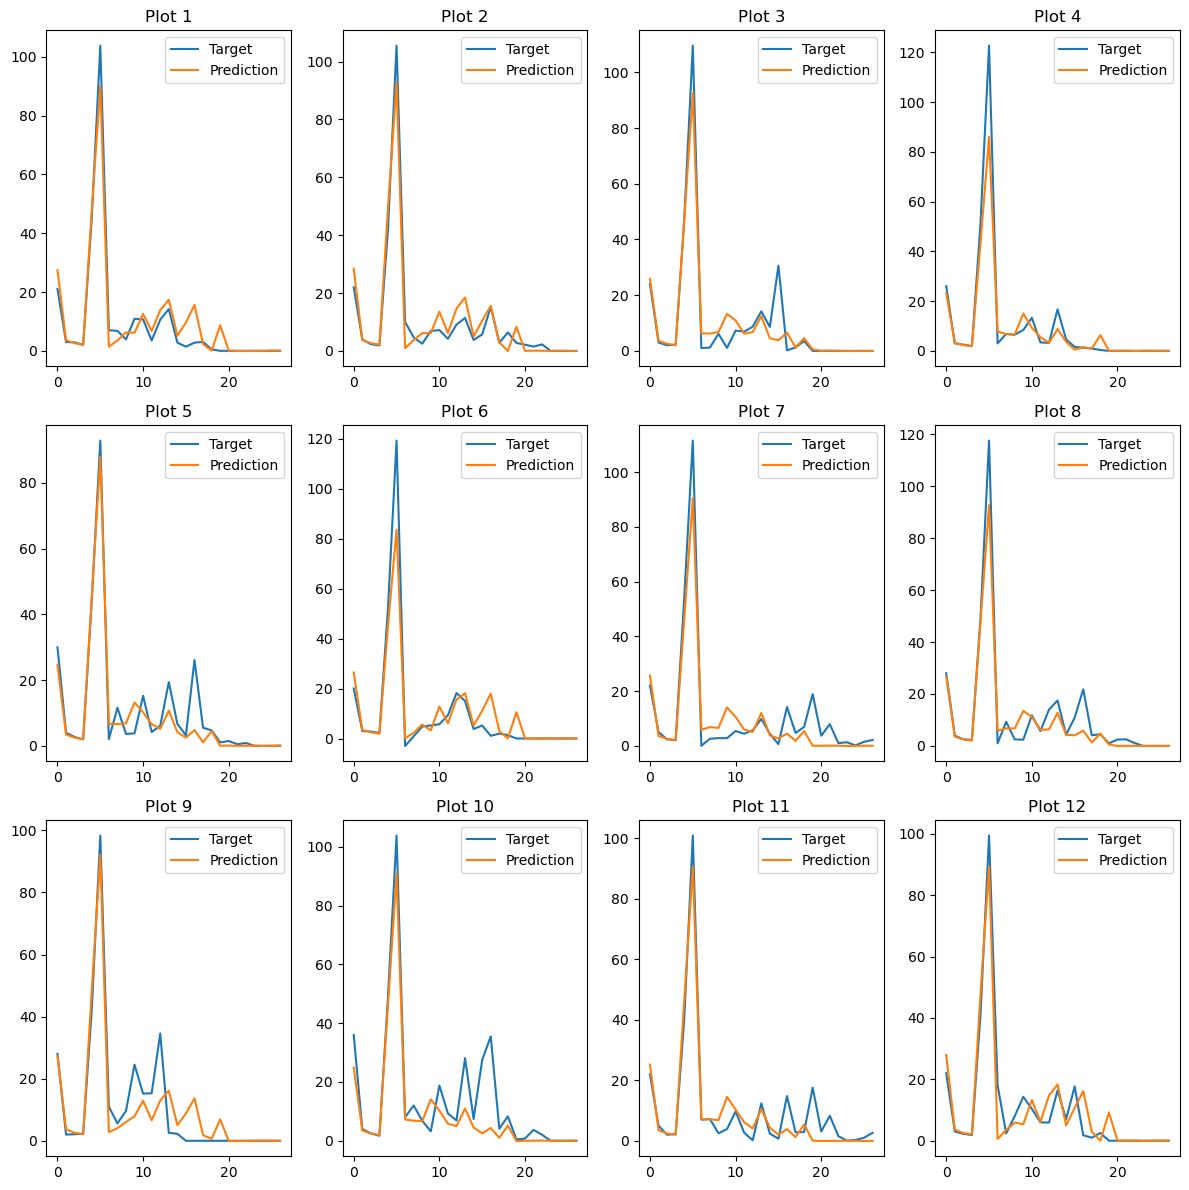

In [8]:
for i in range(3):
    ### 1st round: Enforce variance ###
    EPOCHS= 3
    LR = .0001
    optimizer = torch.optim.Adam(model4.parameters(), lr=LR)
    train_loss4Fine, val_loss4Fine = fit(model4, optimizer, criterion, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
    show_samples(model4)

    ### Second Round: MSELoss ### 
    EPOCHS= 1
    LR = .00005
    optimizer = torch.optim.Adam(model4.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    train_loss4Fine, val_loss4Fine = fit(model4, optimizer, loss_fn, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
    show_samples(model4)


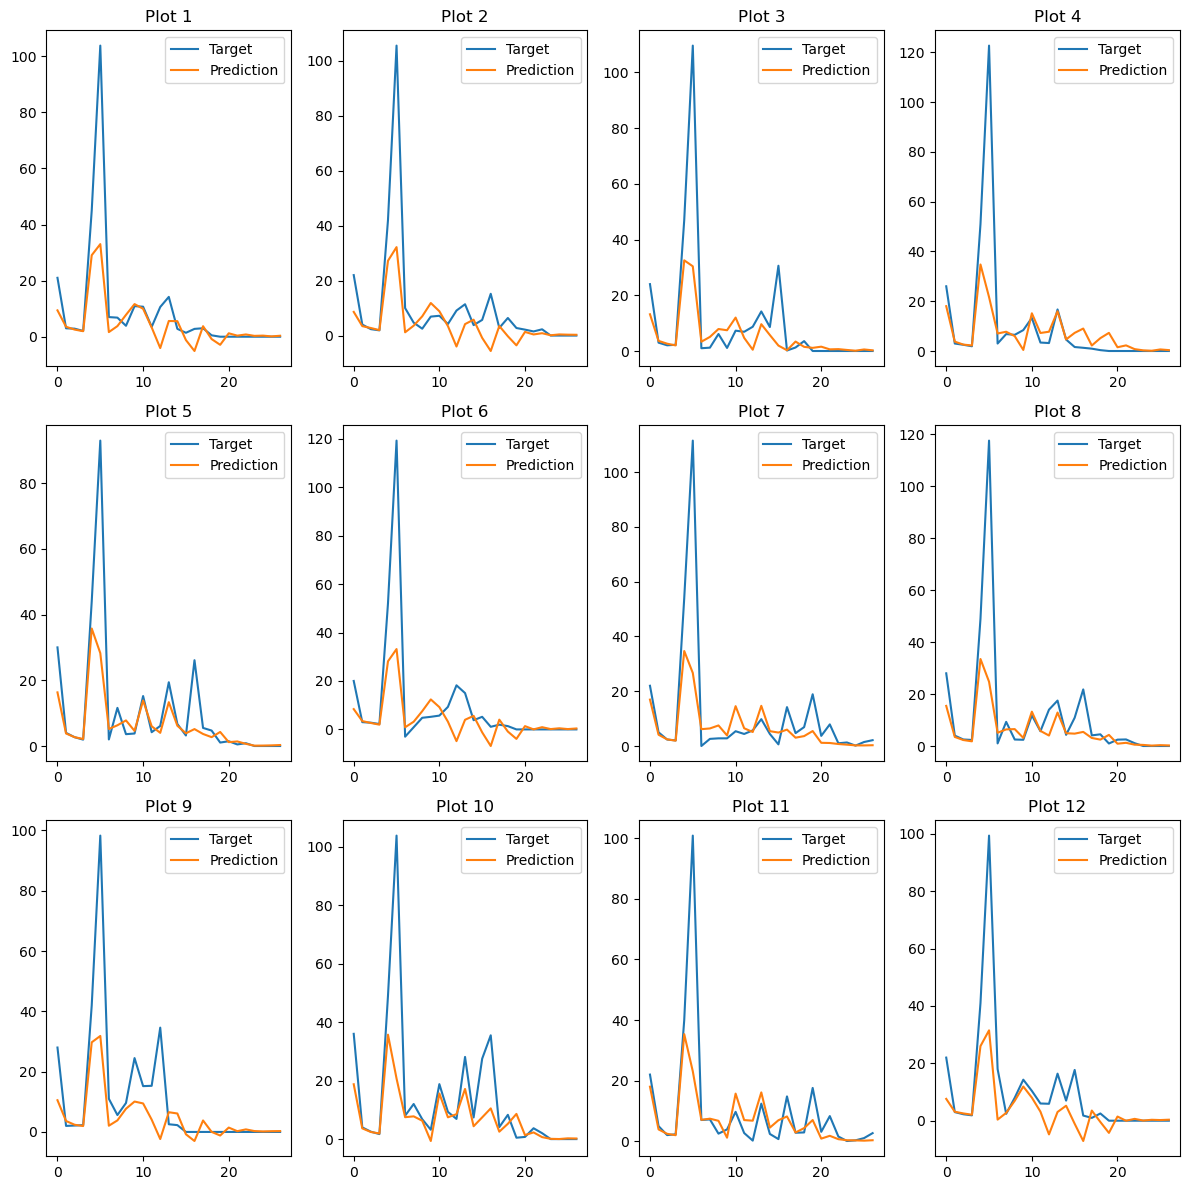

In [29]:
show_samples(model4)

In [16]:
### Third batch ### 
EPOCHS= 1
LR = .00005
optimizer = torch.optim.Adam(model4.parameters(), lr=LR)
loss_fn = nn.MSELoss()
train_loss4Fine, val_loss4Fine = fit(model4, optimizer, loss_fn, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)

[Epoch   1/1]: 100%|██████████| 10000/10000 [01:09<00:00, 146.83it/s, total loss=8.43e+4]

Epoch 0 train_loss: 8.426195182037354


[Epoch   1/1]: 100%|██████████| 10000/10000 [01:09<00:00, 143.16it/s, total loss=8.43e+4]

Epoch 0 val_loss: 2.2930544726053874


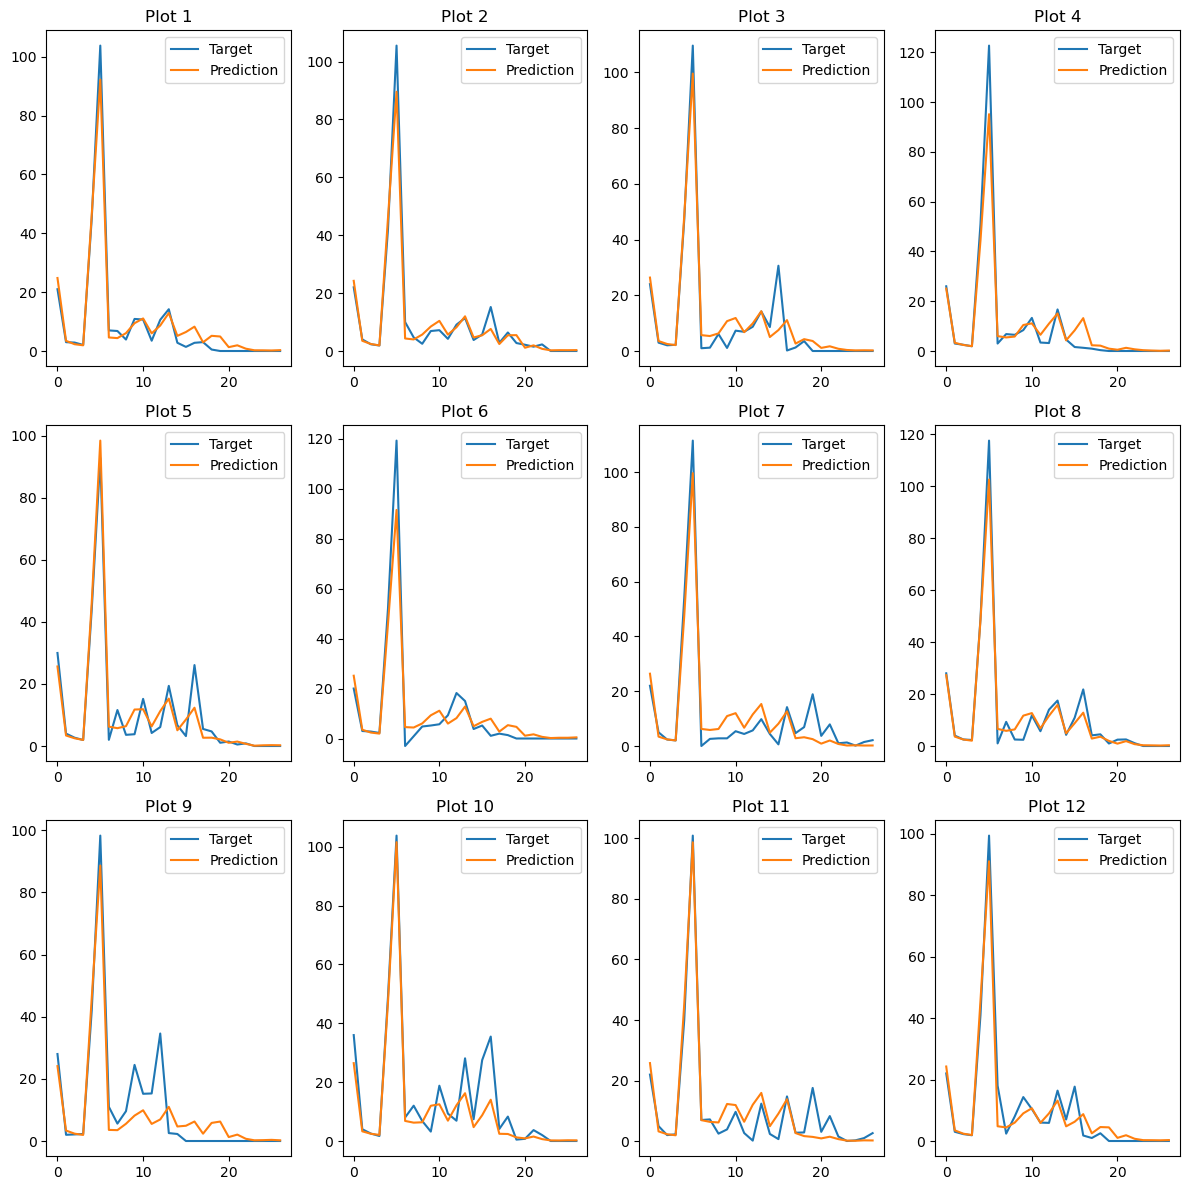

In [17]:
### Third batch ### 
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

dataloader_val = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

for x, y in dataloader_val:
    break

for i, ax in enumerate(axs.flat):
    X = model4(x.float())[i]
    X = X.detach().numpy()
    ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

In [165]:
# Second round: Enforce variance
EPOCHS= 1
LR = .0005
optimizer = torch.optim.Adam(model4.parameters(), lr=LR)
train_loss4Fine, val_loss4Fine = fit(model4, optimizer, criterion, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)

[Epoch   1/1]: 100%|█████████▉| 9998/10000 [03:24<00:00, 50.15it/s, total loss=2.2e+7]

Epoch 0 train_loss: 2200.2619066635134


[Epoch   1/1]: 100%|██████████| 10000/10000 [03:24<00:00, 48.87it/s, total loss=2.2e+7]

Epoch 0 val_loss: 135.06373229980468


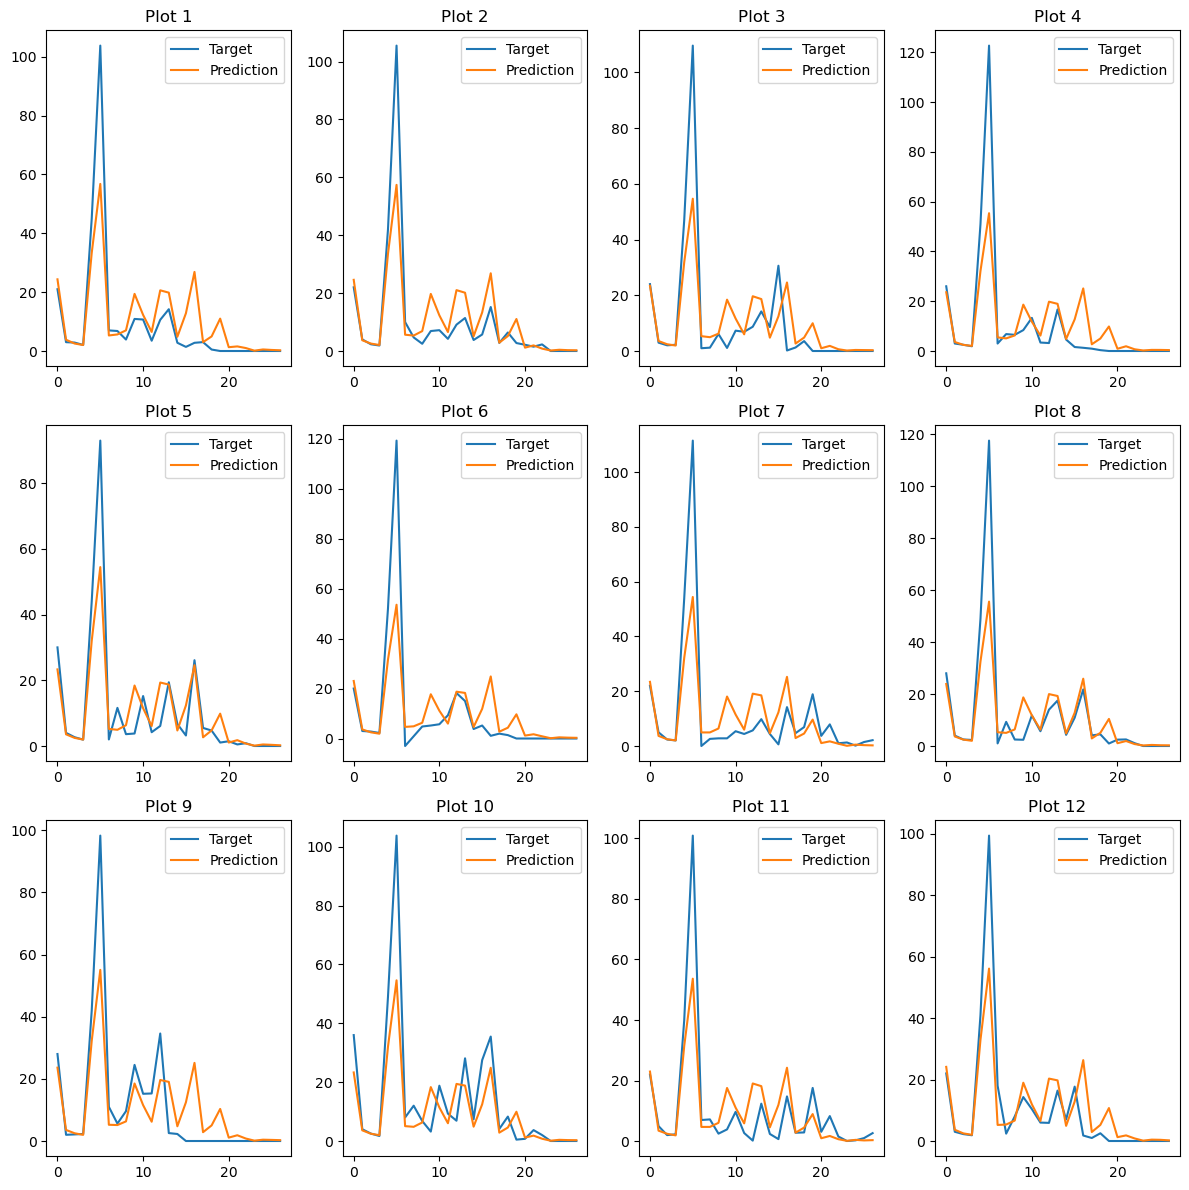

In [166]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

dataloader_val = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

for x, y in dataloader_val:
    break

for i, ax in enumerate(axs.flat):
    X = model4(x.float())[i]
    X = X.detach().numpy()
    ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

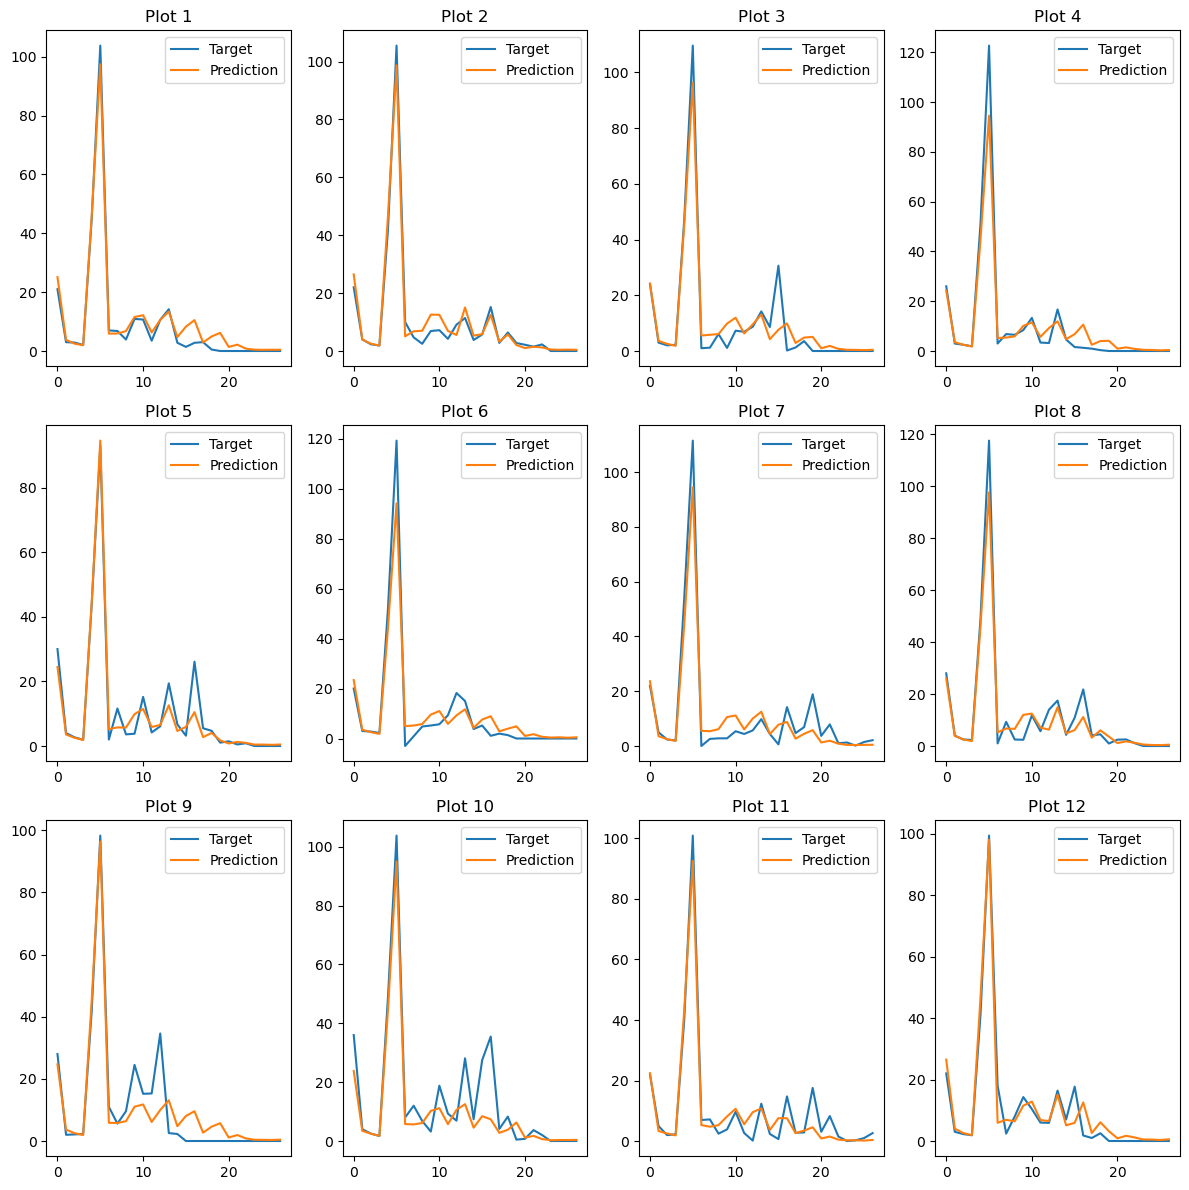

In [152]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

dataloader_val = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

for x, y in dataloader_val:
    break

for i, ax in enumerate(axs.flat):
    X = model4(x.float())[i]
    X = X.detach().numpy()
    ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

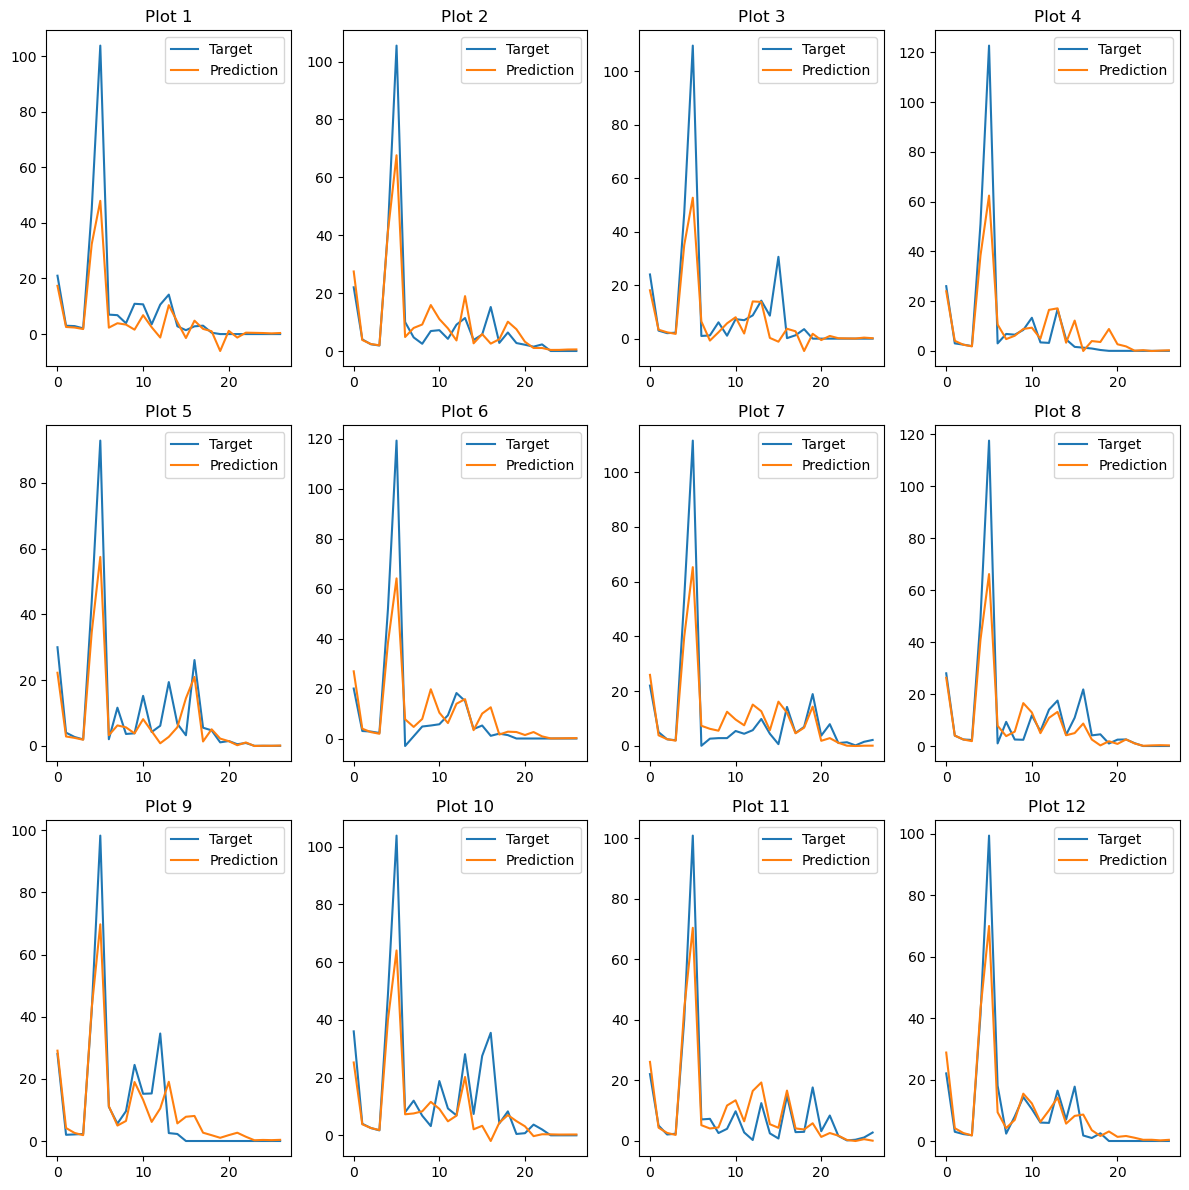

In [150]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

dataloader_val = DataLoader(data_val, batch_size=12, shuffle=False, num_workers=N_WORKERS)

for x, y in dataloader_val:
    break

for i, ax in enumerate(axs.flat):
    X = model4(x.float())[i]
    X = X.detach().numpy()
    ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

# Model 6 (Rapid Convergence, variance enforcement)

In [65]:
## Model 5 Architecture ##

d_input = 5 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10


# Model hyperparameters
BATCH_SIZE = 50
D_MODEL = 32 # Best: 24
q = 6 
v = 6
h = 6
Ne =4
Nd = 4
DROPOUT = 0.3 # Best: 3


model6 = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, DROPOUT, noise_scale=0.35) 
model6.init_weights()
model_save_path = f'Checkpoints/model6_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'


dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

varMSE = nn.MSELoss()
mse = nn.MSELoss()

#### Custom Loss Function ####
def var_loss(outputs, targets): 
    return varMSE(torch.var(outputs, dim=0), torch.var(targets, dim=0))

def criterion(outputs, targets):
    return var_loss(outputs, targets) + mse(outputs, targets)



[Epoch   1/6]: 100%|██████████| 10000/10000 [00:18<00:00, 540.12it/s, total loss=2.47e+5]


Epoch 0 train_loss: 24.737998516845703
Epoch 0 val_loss: 9.30969757080078


[Epoch   2/6]: 100%|██████████| 10000/10000 [00:19<00:00, 503.61it/s, total loss=9.01e+4]


Epoch 1 train_loss: 9.008784652709961
Epoch 1 val_loss: 7.511082255045573


[Epoch   3/6]: 100%|██████████| 10000/10000 [00:17<00:00, 567.64it/s, total loss=7.33e+4]


Epoch 2 train_loss: 7.331963493347168
Epoch 2 val_loss: 5.952995096842448


[Epoch   4/6]: 100%|██████████| 10000/10000 [00:19<00:00, 516.28it/s, total loss=5.69e+4]


Epoch 3 train_loss: 5.687015156555176
Epoch 3 val_loss: 4.634724426269531


[Epoch   5/6]: 100%|██████████| 10000/10000 [00:17<00:00, 558.07it/s, total loss=4.64e+4]


Epoch 4 train_loss: 4.644211325073242
Epoch 4 val_loss: 4.492648010253906


[Epoch   6/6]: 100%|██████████| 10000/10000 [00:18<00:00, 555.16it/s, total loss=4.13e+4]


Epoch 5 train_loss: 4.133007287597656
Epoch 5 val_loss: 4.251924031575521


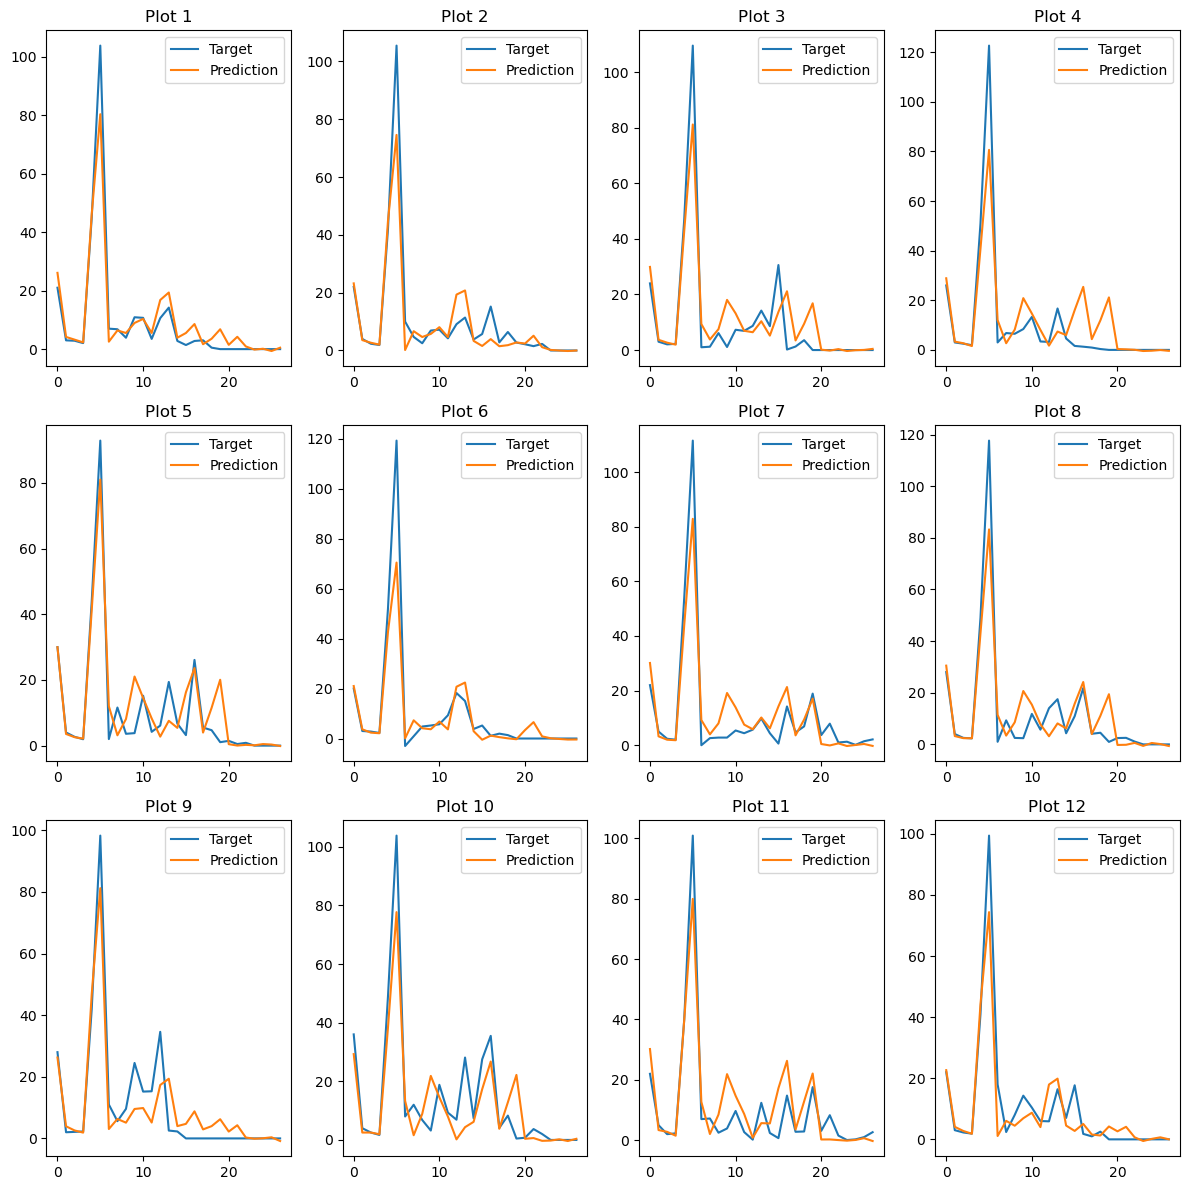

[Epoch   1/1]: 100%|██████████| 10000/10000 [00:17<00:00, 561.79it/s, total loss=7.81e+3]


Epoch 0 train_loss: 0.7812552276611329
Epoch 0 val_loss: 0.4733674685160319


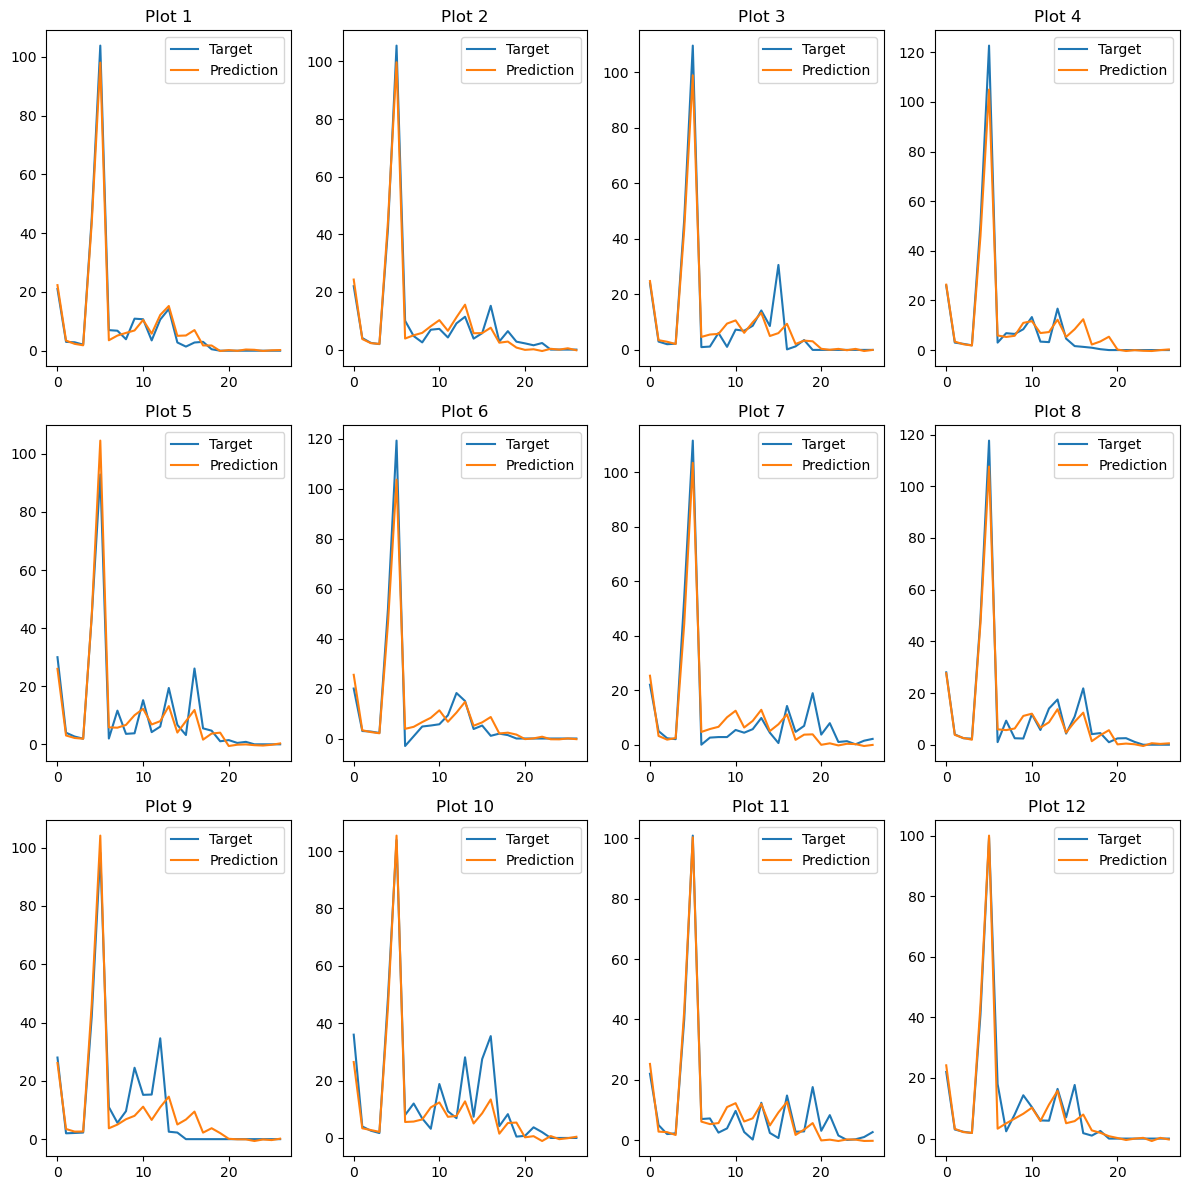

In [66]:
### 1st ROUND: CUSTOM LOSS, 6 EPOCHS ###
EPOCHS= 6 
LR = .0008
v_loss = criterion
optimizer = torch.optim.Adam(model6.parameters(), lr=LR)
train_loss1, val_loss1 = fit(model6, optimizer, v_loss, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
show_samples(model6)


### 2nd round: MSELoss, 1 EPOCH ###
EPOCHS= 1 # 6
LR = .0008

base_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=LR)
train_loss2, val_loss2 = fit(model6, optimizer, base_loss, EPOCHS, model_save_path, perturb=True, noise_scale=0.05)
show_samples(model6)

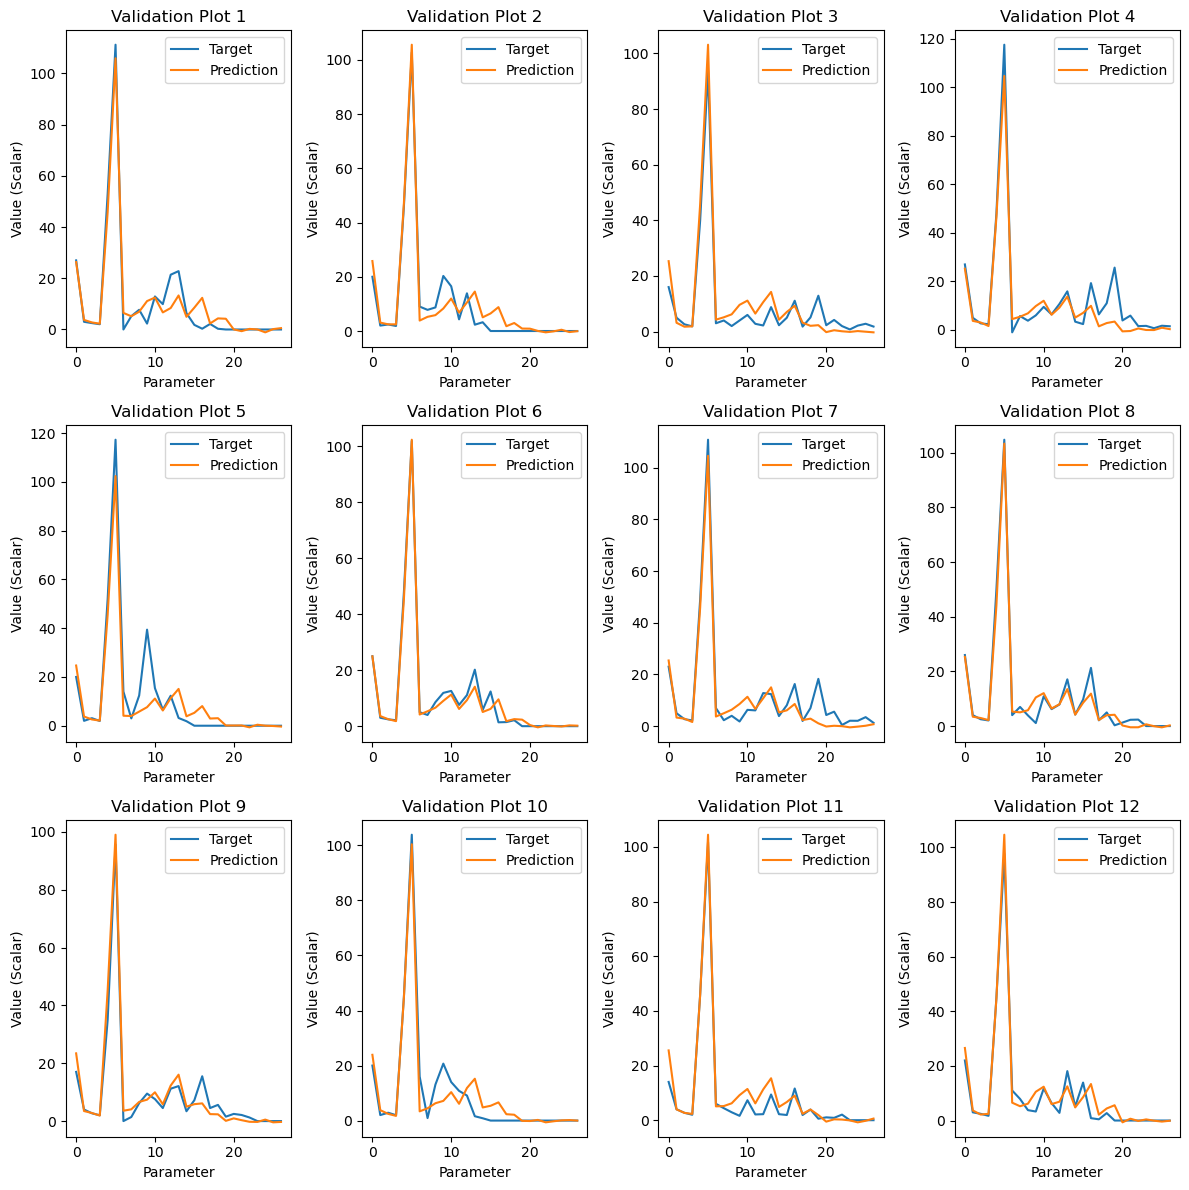

In [75]:
def show_samples(model):
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

    dl = DataLoader(data_val, batch_size=12, shuffle=True, num_workers=N_WORKERS)

    for x, y in dl:
        break

    for i, ax in enumerate(axs.flat):
        X = model(x.float())[i]
        X = X.detach().numpy()
        ax.plot(range(len(y[i])), y[i])
        
        ax.plot(range(len(X)), X)
        ax.legend(["Target", "Prediction"])
        ax.set_title(f"Validation Plot {i+1}")
        ax.set_xlabel("Parameter")
        ax.set_ylabel("Value (Scalar)")
    plt.tight_layout()
    plt.show()

show_samples(model6)

In [84]:
train_loss.append(train_loss2[0])

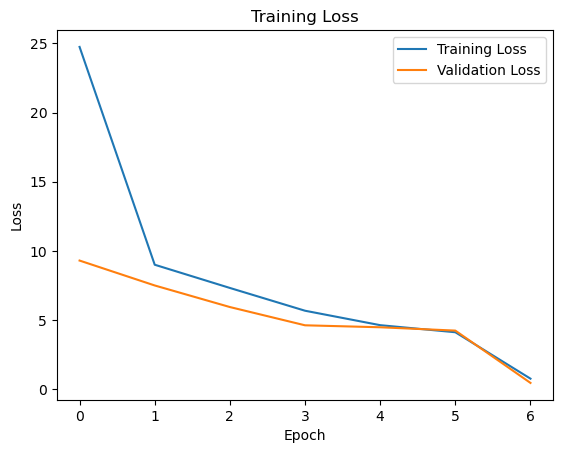

In [96]:
fig, ax = plt.subplots()
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(val_loss)), val_loss)
plt.title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])